In [1]:
import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Часть 1. Классификатор 128×128

Требования к модели:  

* Своя архитектура (разрешается вдохновляться CNN-идеями: Conv-BN-ReLU, блоки с даунсемплингом, GAP и т.д.).
* Ограничение на параметризованность: не более ~5M параметров.
* Вход: 128×128×3.
* Можно выбрать любое количество классов для обучения!  

Обучение:  

* Трен/вал сплит: выберите собственную стратификацию.
* Аугментации: разумные (кроп, флипы, color jitter и т.д.), кратко опишите в отчёте.  

Что сдаём по части 1:  

* График/лог обучения (loss/accuracy по эпохам) и итоговые метрики на валидации.
* Чекпоинт модели (по возможности) или веса/ссылка.  


In [3]:
class TinyImageNetDataset(Dataset):
    def __init__(self, root, split, classes, transform=None):
        """
        root: путь к tiny-imagenet-200
        split: 'train' или 'val'
        classes: список из 10 wnid классов
        """
        self.root = root
        self.split = split
        self.transform = transform
        self.classes = classes
        self.class_to_idx = {cls: i for i, cls in enumerate(classes)}
        self.samples = []

        if split == "train":
            for cls in classes:
                img_dir = os.path.join(root, "train", cls, "images")
                for img_name in os.listdir(img_dir):
                    self.samples.append(
                        (os.path.join(img_dir, img_name), self.class_to_idx[cls])
                    )

        elif split == "test":
            test_img_dir = os.path.join(root, "test", "images")
            for img_name in os.listdir(test_img_dir):
                self.samples.append(
                    (os.path.join(test_img_dir, img_name), -1)  # фиктивная метка
                )

        
        elif split == "val":
            val_img_dir = os.path.join(root, "val", "images")
            ann_file = os.path.join(root, "val", "val_annotations.txt")

            img_to_cls = {}
            with open(ann_file) as f:
                for line in f:
                    img, cls = line.split()[:2]
                    if cls in self.class_to_idx:
                        img_to_cls[img] = self.class_to_idx[cls]

            for img, label in img_to_cls.items():
                self.samples.append(
                    (os.path.join(val_img_dir, img), label)
                )

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
class DatasetWithTransform(Dataset):
    def __init__(self, dataset, indices, transform):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        if self.transform:
            image = self.transform(image)
        return image, label


In [5]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128, scale=(0.6, 1.0)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(5),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.05
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

classes = [
    'n02106662',
    'n01882714',
    'n02124075',
    'n02132136',
    'n02395406',
    'n02410509',
    'n02415577',
    'n02423022',
    'n02480495',
    'n02509815'
]

In [6]:
def split_indices(labels, val_ratio=0.1):
    indices = list(range(len(labels)))
    train_idx, val_idx = train_test_split(
        indices,
        test_size=val_ratio,
        stratify=labels,
        random_state=42
    )
    return train_idx, val_idx


**Используем случайную стратификацию train_test_split с сохранением баланса классов (stratify=labels)**

In [7]:
root = "/kaggle/input/tiny-imagenet-zip/tiny-imagenet-200"

base_dataset = TinyImageNetDataset(
    root=root,
    split='train',
    classes=classes,
    transform=None
)

labels = [x[1] for x in base_dataset]

train_idx, val_idx = split_indices(labels, val_ratio=0.1)


train_subset = torch.utils.data.Subset(base_dataset, train_idx)
val_subset   = torch.utils.data.Subset(base_dataset, val_idx)

train_dataset = DatasetWithTransform(
    base_dataset,
    train_idx,
    train_transform
)

val_dataset = DatasetWithTransform(
    base_dataset,
    val_idx,
    val_transform
)


train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4
)

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")
print(f"Классов: {len(classes)}")

Train size: 4500
Val size: 500
Классов: 10


Для обучения применены аугментации: RandomResizedCrop для увеличения вариативности кадров, RandomHorizontalFlip для отражений, ColorJitter для изменения освещённости и контрастности, а также небольшая RandomRotation для ориентационной вариации. По идее должно снизить переобучение и повысить устойчивость модели. Для валидации использовались только Resize и Normalize.

## Архитектура модели

In [8]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, activation="relu"):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.activation = self._get_activation(activation)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def _get_activation(self, name):
        match name.lower():
            case "relu":
                return nn.ReLU(inplace=True)
            case "leakyrelu":
                return nn.LeakyReLU(inplace=True)
            case "elu":
                return nn.ELU(inplace=True)
            case "gelu":
                return nn.GELU()
            case _:
                raise ValueError(f"Unknown activation: {name}")

    def forward(self, x):
        identity = x

        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity
        out = self.activation(out)

        return out


Базовый блок представляет собой residual-модуль, состоящий из двух последовательных свёрточных слоёв 3×3 с Batch Normalization и функцией активации ReLU. При необходимости изменения пространственного разрешения или числа каналов используется путь проекции с помощью 1×1 свёртки (downsample). Также используется residual connection

In [9]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10, activation="relu", use_maxpool=True):
        super().__init__()

        # Stem
        self.conv1 = nn.Conv2d(
            3, 64,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.activation = self._get_activation(activation)

        self.maxpool = (
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
            if use_maxpool else nn.Identity()
        )

        # Слой 1: 32 каналов
        self.block1_1 = BasicBlock(64, 64, stride=1, activation=activation)
        self.block1_2 = BasicBlock(64, 64, stride=1, activation=activation)

        # Слой 2: 64 каналов
        self.block2_1 = BasicBlock(64, 128, stride=2, activation=activation)
        self.block2_2 = BasicBlock(128, 128, stride=1, activation=activation)

        # Слой 3: 128 каналов
        self.block3_1 = BasicBlock(128, 256, stride=2, activation=activation)
        self.block3_2 = BasicBlock(256, 256, stride=1, activation=activation)

        # Голова
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _get_activation(self, name):
        match name.lower():
            case "relu":
                return nn.ReLU(inplace=True)
            case "leakyrelu":
                return nn.LeakyReLU(inplace=True)
            case "elu":
                return nn.ELU(inplace=True)
            case "gelu":
                return nn.GELU()
            case _:
                raise ValueError(f"Unknown activation: {name}")

    def forward(self, x):
        # Stem
        x = self.activation(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        # Слой 1
        x = self.block1_1(x)
        x = self.block1_2(x)

        # Слой 2
        x = self.block2_1(x)
        x = self.block2_2(x)

        # Слой 3
        x = self.block3_1(x)
        x = self.block3_2(x)

        # Голова
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [10]:
custom_cnn = CustomCNN(num_classes=10)

In [88]:
model = CustomCNN(num_classes=10)
model = model.to(device)
x = torch.randn(1, 3, 128, 128).to(device)
y = model(x)
print(y.shape)  # torch.Size([1, 10])
print(f"Всего параметров: {sum(p.numel() for p in model.parameters()):,}")

torch.Size([1, 10])
Всего параметров: 2,777,674


Использовалась собственная сверточная нейронная сеть с residual-блоками. Архитектура состоит из последовательных стадий Conv-BN-ReLU с даунсемплингом и увеличением числа каналов. Для агрегации признаков применялся Global Average Pooling, что позволило сократить число параметров. Общее число параметров модели не превышает 5 млн.

## Обучение

In [11]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy

In [12]:
@torch.no_grad()
def validate_one_epoch(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Val", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy


In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, model_name, num_epochs=10):
    """
    Обучает модель и возвращает метрики для визуализации.

    Возвращает:
        train_losses, val_losses, train_accs, val_accs
    """
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []
    best_val_acc = 0.0
    
    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch [{epoch}/{num_epochs}]")

        # Train
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validation
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        # Сохраняем метрики
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
            f"|| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_name)
            print(f" Сохранена лучшая модель с точностью {val_acc*100:.2f}%")

    return train_losses, val_losses, train_accs, val_accs

In [92]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.001
)

device

device(type='cuda')

In [94]:
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader, criterion, optimizer, device, 'CNN_tiny_imagenet_model.pth', num_epochs=40)


Epoch [1/40]


Train Loss: 1.5352 | Train Acc: 0.4816 || Val Loss: 1.5383 | Val Acc: 0.4820
 Сохранена лучшая модель с точностью 48.20%

Epoch [2/40]


Train Loss: 1.4775 | Train Acc: 0.4951 || Val Loss: 1.5371 | Val Acc: 0.4840
 Сохранена лучшая модель с точностью 48.40%

Epoch [3/40]


Train Loss: 1.4454 | Train Acc: 0.5056 || Val Loss: 1.5339 | Val Acc: 0.4940
 Сохранена лучшая модель с точностью 49.40%

Epoch [4/40]


Train Loss: 1.3985 | Train Acc: 0.5253 || Val Loss: 1.3815 | Val Acc: 0.5380
 Сохранена лучшая модель с точностью 53.80%

Epoch [5/40]


Train Loss: 1.3769 | Train Acc: 0.5320 || Val Loss: 1.2788 | Val Acc: 0.5840
 Сохранена лучшая модель с точностью 58.40%

Epoch [6/40]


Train Loss: 1.3329 | Train Acc: 0.5471 || Val Loss: 1.2907 | Val Acc: 0.5700

Epoch [7/40]


Train Loss: 1.3155 | Train Acc: 0.5593 || Val Loss: 1.2246 | Val Acc: 0.5780

Epoch [8/40]


Train Loss: 1.2572 | Train Acc: 0.5802 || Val Loss: 1.3353 | Val Acc: 0.5500

Epoch [9/40]


Train Loss: 1.2301 | Train Acc: 0.5867 || Val Loss: 1.2622 | Val Acc: 0.5920
 Сохранена лучшая модель с точностью 59.20%

Epoch [10/40]


Train Loss: 1.2199 | Train Acc: 0.5858 || Val Loss: 1.2581 | Val Acc: 0.6000
 Сохранена лучшая модель с точностью 60.00%

Epoch [11/40]


Train Loss: 1.1688 | Train Acc: 0.6042 || Val Loss: 1.2533 | Val Acc: 0.5780

Epoch [12/40]


Train Loss: 1.1442 | Train Acc: 0.6131 || Val Loss: 1.1459 | Val Acc: 0.6220
 Сохранена лучшая модель с точностью 62.20%

Epoch [13/40]


Train Loss: 1.1156 | Train Acc: 0.6244 || Val Loss: 1.1556 | Val Acc: 0.6340
 Сохранена лучшая модель с точностью 63.40%

Epoch [14/40]


Train Loss: 1.0954 | Train Acc: 0.6347 || Val Loss: 1.0961 | Val Acc: 0.6280

Epoch [15/40]


Train Loss: 1.0803 | Train Acc: 0.6393 || Val Loss: 1.1081 | Val Acc: 0.5960

Epoch [16/40]


Train Loss: 1.0450 | Train Acc: 0.6464 || Val Loss: 1.0892 | Val Acc: 0.6480
 Сохранена лучшая модель с точностью 64.80%

Epoch [17/40]


Train Loss: 0.9872 | Train Acc: 0.6682 || Val Loss: 1.0836 | Val Acc: 0.6600
 Сохранена лучшая модель с точностью 66.00%

Epoch [18/40]


Train Loss: 0.9968 | Train Acc: 0.6616 || Val Loss: 1.0919 | Val Acc: 0.6500

Epoch [19/40]


Train Loss: 0.9531 | Train Acc: 0.6787 || Val Loss: 1.0438 | Val Acc: 0.6900
 Сохранена лучшая модель с точностью 69.00%

Epoch [20/40]


Train Loss: 0.9301 | Train Acc: 0.6938 || Val Loss: 1.0653 | Val Acc: 0.6420

Epoch [21/40]


Train Loss: 0.9077 | Train Acc: 0.6960 || Val Loss: 1.1593 | Val Acc: 0.6420

Epoch [22/40]


Train Loss: 0.8745 | Train Acc: 0.7038 || Val Loss: 1.1579 | Val Acc: 0.6440

Epoch [23/40]


Train Loss: 0.8567 | Train Acc: 0.7078 || Val Loss: 1.1010 | Val Acc: 0.6520

Epoch [24/40]


Train Loss: 0.8213 | Train Acc: 0.7204 || Val Loss: 1.0649 | Val Acc: 0.6620

Epoch [26/40]


Train Loss: 0.7787 | Train Acc: 0.7407 || Val Loss: 0.9702 | Val Acc: 0.7060
 Сохранена лучшая модель с точностью 70.60%

Epoch [27/40]


Train Loss: 0.7556 | Train Acc: 0.7424 || Val Loss: 0.9794 | Val Acc: 0.6760

Epoch [28/40]


Train Loss: 0.7737 | Train Acc: 0.7398 || Val Loss: 0.9846 | Val Acc: 0.6740

Epoch [29/40]


Train Loss: 0.7476 | Train Acc: 0.7564 || Val Loss: 1.0524 | Val Acc: 0.6840

Epoch [30/40]


Train Loss: 0.6987 | Train Acc: 0.7624 || Val Loss: 1.0449 | Val Acc: 0.6980

Epoch [31/40]


Train Loss: 0.6733 | Train Acc: 0.7769 || Val Loss: 1.0676 | Val Acc: 0.6660

Epoch [32/40]


Train Loss: 0.6604 | Train Acc: 0.7816 || Val Loss: 1.0293 | Val Acc: 0.6780

Epoch [33/40]


Train Loss: 0.6437 | Train Acc: 0.7864 || Val Loss: 0.9143 | Val Acc: 0.7040

Epoch [34/40]


Train Loss: 0.6157 | Train Acc: 0.7911 || Val Loss: 1.0692 | Val Acc: 0.6900

Epoch [35/40]


Train Loss: 0.6107 | Train Acc: 0.7896 || Val Loss: 1.0721 | Val Acc: 0.7000

Epoch [36/40]


Train Loss: 0.5901 | Train Acc: 0.8096 || Val Loss: 1.0003 | Val Acc: 0.7000

Epoch [37/40]


Train Loss: 0.5633 | Train Acc: 0.8076 || Val Loss: 0.9708 | Val Acc: 0.7000

Epoch [38/40]


Train Loss: 0.5533 | Train Acc: 0.8122 || Val Loss: 1.0217 | Val Acc: 0.6760

Epoch [39/40]


Train Loss: 0.5475 | Train Acc: 0.8149 || Val Loss: 0.9489 | Val Acc: 0.7020

Epoch [40/40]


Train Loss: 0.5209 | Train Acc: 0.8253 || Val Loss: 0.9823 | Val Acc: 0.7080
 Сохранена лучшая модель с точностью 70.80%


In [14]:
def plot_training_curves(train_losses, val_losses, train_accs, val_accs):
    """
    Визуализирует кривые обучения для Loss и Accuracy.
    
    train_losses, val_losses: списки loss на каждой эпохе
    train_accs, val_accs: списки accuracy на каждой эпохе
    """
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss", marker='o')
    plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Accuracy", marker='o')
    plt.plot(epochs, val_accs, label="Validation Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

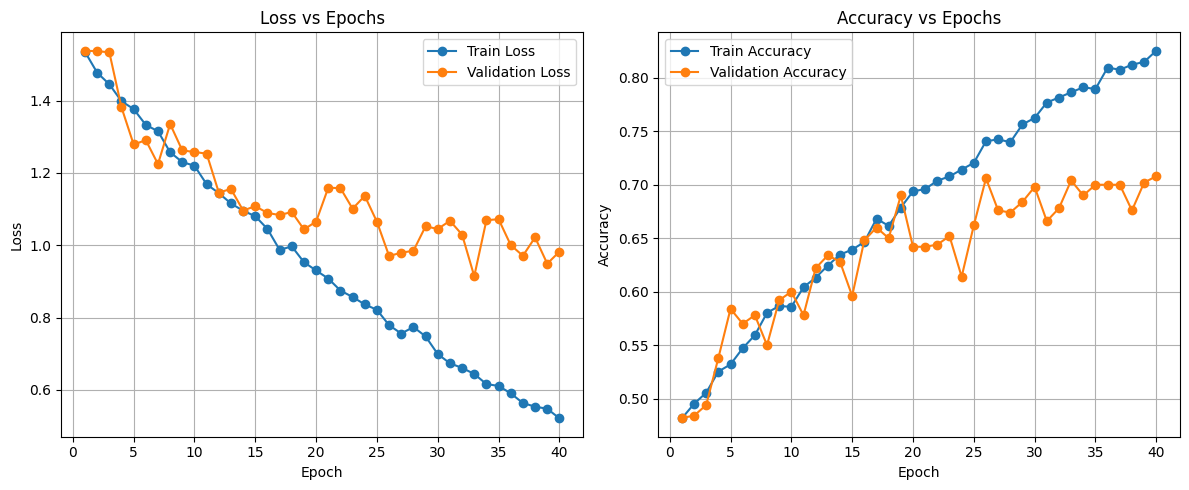

In [98]:
plot_training_curves(train_losses, val_losses, train_accs, val_accs)

Лучший Val Accuracy = 70.8% на 40 эпохе

## Проверка инференса

In [191]:
best_model = CustomCNN(num_classes=10).to(device)
best_model.load_state_dict(torch.load('/kaggle/working/CNN_tiny_imagenet_model.pth'))
best_model.eval()

print('model loaded')

model loaded


In [193]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import torch

best_model.eval()
best_model.to(device)

all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        outputs = best_model(imgs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print("Classification Report:")
print(classification_report(all_labels, all_preds))

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85        50
           1       0.81      0.70      0.75        50
           2       0.77      0.54      0.64        50
           3       0.62      0.56      0.59        50
           4       0.77      0.48      0.59        50
           5       0.65      0.80      0.71        50
           6       0.60      0.64      0.62        50
           7       0.75      0.84      0.79        50
           8       0.52      0.86      0.65        50
           9       0.93      0.82      0.87        50

    accuracy                           0.71       500
   macro avg       0.73      0.71      0.71       500
weighted avg       0.73      0.71      0.71       500

Confusion Matrix:
[[42  1  2  0  1  0  2  0  2  0]
 [ 0 35  1  2  0  1  5  1  5  0]
 [ 6  3 27  1  1  2  2  2  6  0]
 [ 1  1  0 28  0  8  3  2  6  1]
 [ 0  1  4  6 24  6  4  2  2  1]
 [ 0  0  0  3  1 40  1  0  5  0]
 [

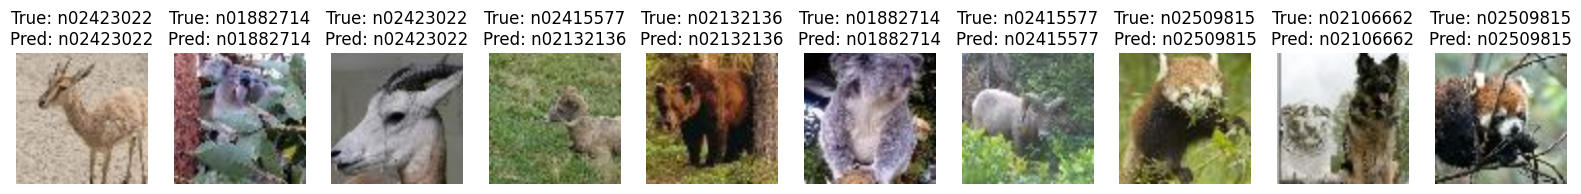

In [195]:
# Выбираем 10 случайных индексов
indices = random.sample(range(len(val_loader.dataset)), 10)

plt.figure(figsize=(20, 4))

for i, idx in enumerate(indices):
    image, label = val_loader.dataset[idx]
    input_img = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = best_model(input_img)
        pred = output.argmax(dim=1).item()

    plt.subplot(1, 10, i + 1)
    # Тензор (C,H,W) → numpy (H,W,C)
    img_np = image.permute(1, 2, 0).cpu().numpy()
    # Нормализуем обратно для отображения
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"True: {classes[label]}\nPred: {classes[pred]}")

plt.show()

Довольно хорошо угадало на рандомных 10 семплах, но наверное можно еще пообучать модель

# Часть 2. Базовая U-Net на "Луне"

## Создание кастомного Dataset для Moon Segmentation

### Структура данных:
- **render/** - исходные изображения лунной поверхности (1000 изображений)
- **ground/** - бинарные маски сегментации (0 = фон, 255 = камни)



In [15]:
class MoonSegmentationDataset(Dataset):

    def __init__(self, root_dir, image_folder='render', mask_folder='ground', 
                 image_ids=None, augmentation=None, preprocessing=None):
        self.root_dir = root_dir
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        images_dir = os.path.join(root_dir, 'images', image_folder)
        masks_dir = os.path.join(root_dir, 'images', mask_folder)
        
        if image_ids is None:
            all_images = os.listdir(images_dir)
            self.image_ids = [img.replace('.png', '') for img in all_images if img.endswith('.png')]
        else:
            self.image_ids = image_ids
        
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        
        image_path = os.path.join(self.root_dir, 'images', self.image_folder, f"{image_id}.png")
        
        # Для масок убираем префикс "render" если он есть
        # Например: render0001 - 0001
        mask_id = image_id.replace('render', '') if 'render' in image_id else image_id
        mask_path = os.path.join(self.root_dir, 'images', self.mask_folder, f"ground{mask_id}.png")
        
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Так как используем opencv, то не забываем преводить из BGR в RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Нормализуем бинарную маску к [0, 1]
        # 0 = фон, 1 = камни
        mask = (mask > 0).astype(np.float32)
        
        # Применяем аугментации
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # Применяем предобработку
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask


In [16]:
# Аугментации для обучения
train_augmentation = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=45, p=0.5),
    A.OneOf([
        A.GaussNoise(var_limit=(10.0, 50.0)),
        A.GaussianBlur(blur_limit=(3, 7)),
        A.MedianBlur(blur_limit=5),
    ], p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
])

preprocessing = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_augmentation = A.Compose([
    A.Resize(128, 128),
])



/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_55/4057520275.py:9: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0)),


### Разделение данных на train/val


In [17]:
# Путь к данным
DATA_ROOT = "/kaggle/input/moon-segmentation-binary/MOON_SEGMENTATION_BINARY"

images_dir = os.path.join(DATA_ROOT, 'images', 'render')
all_images = [img.replace('.png', '') for img in os.listdir(images_dir) if img.endswith('.png')][:100]

print(f"Всего изображений: {len(all_images)}")

train_ids, val_ids = train_test_split(all_images, test_size=0.2, random_state=42)

print(f"Train: {len(train_ids)} изображений")
print(f"Val: {len(val_ids)} изображений")

train_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=train_ids,
    augmentation=train_augmentation,
    preprocessing=preprocessing
)

val_dataset = MoonSegmentationDataset(
    root_dir=DATA_ROOT,
    image_folder='render',
    mask_folder='ground',
    image_ids=val_ids,
    augmentation=val_augmentation,
    preprocessing=preprocessing
)

BATCH_SIZE = 4
NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Батчей в train: {len(train_loader)}")
print(f"Батчей в val: {len(val_loader)}")


Всего изображений: 100
Train: 80 изображений
Val: 20 изображений
Батчей в train: 20
Батчей в val: 5


## Визуализация данных

Посмотрим на примеры изображений и их маски сегментации


Размер батча изображений: torch.Size([4, 3, 128, 128])
Размер батча масок: torch.Size([4, 128, 128])


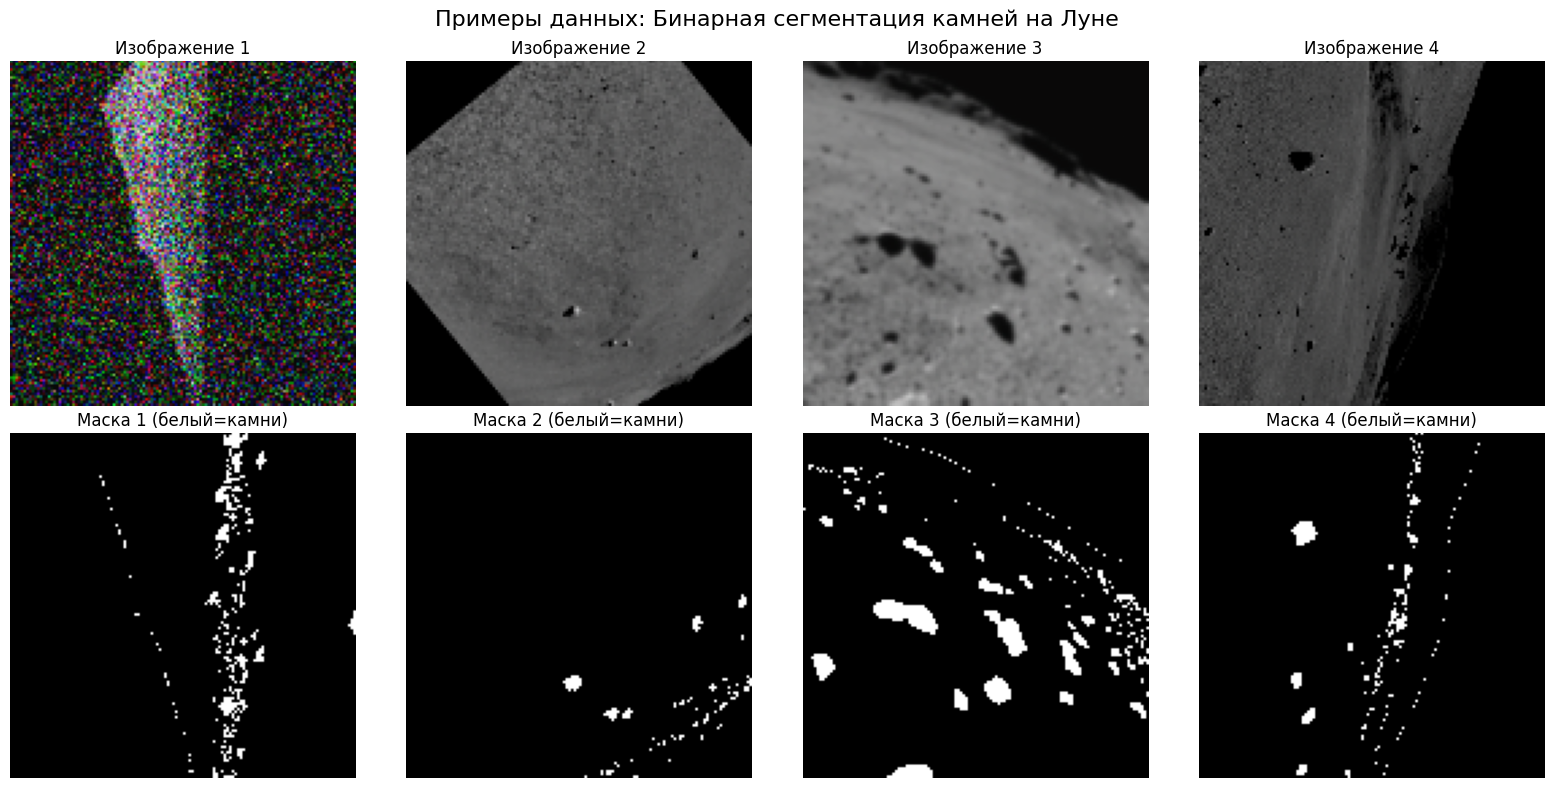

In [18]:
def denormalize(img_tensor):
    """Денормализация изображения для визуализации"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    return img.clamp(0, 1)

images, masks = next(iter(train_loader))

print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча масок: {masks.shape}")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i in range(min(4, len(images))):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    mask = masks[i].numpy()
    
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Изображение {i+1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(mask, cmap='gray')
    axes[1, i].set_title(f"Маска {i+1} (белый=камни)")
    axes[1, i].axis('off')

plt.suptitle("Примеры данных: Бинарная сегментация камней на Луне", fontsize=16)
plt.tight_layout()
plt.show()


## Кастомная U-net архитектура


In [19]:
class DoubleConvDS(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()

        self.block = nn.Sequential(
            # Depthwise
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1,
                      groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),

            # Pointwise
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Dropout2d(dropout)
        )

    def forward(self, x):
        return self.block(x)


### Полная кастомная U-Net архитектура


In [20]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256]):
        super().__init__()

        self.encoder_blocks = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(2)

        # Encoder
        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(
                DoubleConvDS(prev_channels, feature)
            )
            prev_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConvDS(features[-1], features[-1] * 2)

        # Decoder
        for feature in reversed(features):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=3, stride=2)
            )
            self.decoder_blocks.append(
                DoubleConvDS(feature * 2, feature)
            )

        # Final
        self.final_conv = nn.Sequential(
            nn.Conv2d(features[0], out_channels, kernel_size=1),
            nn.Sigmoid()
        )

        total_params = sum(p.numel() for p in self.parameters())
        print(f"Параметров: {total_params:,}")
        print(f"Encoder уровней: {len(features)}")
        print(f"Каналы: {features}")

    def forward(self, x):
        skip_connections = []

        for encoder in self.encoder_blocks:
            x = encoder(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            skip = skip_connections[idx // 2]

            if x.shape[2:] != skip.shape[2:]:
                x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=False)

            x = torch.cat([skip, x], dim=1)
            x = self.decoder_blocks[idx + 1](x)

        return self.final_conv(x)

In [178]:
model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 256])

test_input = torch.randn(1, 3, 128, 128)
test_output = model(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

Параметров: 1,934,306
Encoder уровней: 4
Каналы: [32, 64, 128, 256]
   Вход:  torch.Size([1, 3, 128, 128])
   Выход: torch.Size([1, 1, 128, 128])


---

## Функции потерь и метрики для сегментации

### Метрики сегментации:
- **Dice Loss** - популярная функция потерь для сегментации
- **IoU (Intersection over Union)** - метрика качества сегментации
- **Pixel Accuracy** - точность предсказания пикселей


In [25]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, predictions, targets):
        predictions = predictions.view(-1)
        targets = targets.view(-1)

        intersection = (predictions * targets).sum()
        dice = (2. * intersection + self.smooth) / (predictions.sum() + targets.sum() + self.smooth)

        return 1 - dice


class CombinedLoss(nn.Module):

    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()

    def forward(self, predictions, targets):
        bce_loss = self.bce(predictions, targets)
        dice_loss = self.dice(predictions, targets)

        return self.bce_weight * bce_loss + self.dice_weight * dice_loss


def dice_coefficient(predictions, targets, threshold=0.5, smooth=1e-6):
    predictions = (predictions > threshold).float()

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    dice = (2. * intersection + smooth) / (predictions.sum() + targets.sum() + smooth)

    return dice.item()

def iou_score(predictions, targets, threshold=0.5, smooth=1e-6):
    predictions = (predictions > threshold).float()

    predictions = predictions.view(-1)
    targets = targets.view(-1)

    intersection = (predictions * targets).sum()
    union = predictions.sum() + targets.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)

    return iou.item()


def pixel_accuracy(predictions, targets, threshold=0.5):
    predictions = (predictions > threshold).float()
    correct = (predictions == targets).float().sum()
    total = targets.numel()

    return (correct / total).item()

In [26]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()

    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0

    pbar = tqdm(train_loader, desc="Training")

    for images, masks in pbar:
        images = images.to(device)
        masks = masks.unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, masks)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)

        running_loss += loss.item()
        running_dice += dice
        running_iou += iou

        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice:.4f}',
            'iou': f'{iou:.4f}'
        })

    avg_loss = running_loss / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_iou = running_iou / len(train_loader)

    return avg_loss, avg_dice, avg_iou

In [27]:
def validate_epoch(model, val_loader, criterion, device):

    model.eval()

    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0
    running_acc = 0.0

    pbar = tqdm(val_loader, desc="Validation")

    with torch.no_grad():
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.unsqueeze(1).to(device)

            outputs = model(images)

            loss = criterion(outputs, masks)

            dice = dice_coefficient(outputs, masks)
            iou = iou_score(outputs, masks)
            acc = pixel_accuracy(outputs, masks)

            running_loss += loss.item()
            running_dice += dice
            running_iou += iou
            running_acc += acc

            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice:.4f}',
                'iou': f'{iou:.4f}',
                'acc': f'{acc:.4f}'
            })

    avg_loss = running_loss / len(val_loader)
    avg_dice = running_dice / len(val_loader)
    avg_iou = running_iou / len(val_loader)
    avg_acc = running_acc / len(val_loader)

    return avg_loss, avg_dice, avg_iou, avg_acc

### Основной цикл обучения


In [28]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, save_path='best_unet.pth'):

    model = model.to(device)

    history = {
        'train_loss': [],
        'train_dice': [],
        'train_iou': [],
        'val_loss': [],
        'val_dice': [],
        'val_iou': [],
        'val_acc': [],
        'lr': []
    }

    best_val_dice = 0.0

    for epoch in range(num_epochs):
        print(f"Эпоха {epoch+1}/{num_epochs}")

        train_loss, train_dice, train_iou = train_epoch(
            model, train_loader, criterion, optimizer, device
        )
        val_loss, val_dice, val_iou, val_acc = validate_epoch(
            model, val_loader, criterion, device
        )
        if scheduler is not None:
            scheduler.step(val_dice)
            current_lr = optimizer.param_groups[0]['lr']
        else:
            current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_iou'].append(train_iou)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_acc'].append(val_acc)
        history['lr'].append(current_lr)

        print(f"\n Результаты эпохи {epoch+1}:")
        print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_dice:.4f}, IoU: {train_iou:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_dice:.4f}, IoU: {val_iou:.4f}, Acc: {val_acc:.4f}")
        print(f"  LR: {current_lr:.6f}")

        if val_dice > best_val_dice:
            best_val_dice = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_dice': val_dice,
                'val_iou': val_iou,
            }, save_path)
            print(f"  Сохранена лучшая модель! Dice: {val_dice:.4f}")
    print(f"Лучший Val Dice: {best_val_dice:.4f}")

    return history

### Запуск обучения


In [71]:
# Настройка обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Используем устройство: {device}")

model = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 256])

# Функция потерь (комбинированная BCE + Dice)
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Планировщик learning rate (уменьшаем lr при плато)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',
    factor=0.5, 
    patience=3, 
)

NUM_EPOCHS = 5

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=40,
    save_path='best_moon_unet.pth'
)


  Используем устройство: cuda
Параметров: 1,934,306
Encoder уровней: 4
Каналы: [32, 64, 128, 256]
Эпоха 1/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.22it/s, loss=0.7578, dice=0.0001, iou=0.0001, acc=0.7671]



 Результаты эпохи 1:
  Train - Loss: 0.8564, Dice: 0.2301, IoU: 0.1333
  Val   - Loss: 0.8392, Dice: 0.0000, IoU: 0.0000, Acc: 0.8802
  LR: 0.001000
  Сохранена лучшая модель! Dice: 0.0000
Эпоха 2/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.70it/s, loss=0.7218, dice=0.0841, iou=0.0439, acc=0.7754]



 Результаты эпохи 2:
  Train - Loss: 0.8289, Dice: 0.2557, IoU: 0.1496
  Val   - Loss: 0.7893, Dice: 0.0882, IoU: 0.0462, Acc: 0.8834
  LR: 0.001000
  Сохранена лучшая модель! Dice: 0.0882
Эпоха 3/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.63it/s, loss=0.6813, dice=0.4203, iou=0.2660, acc=0.8039]



 Результаты эпохи 3:
  Train - Loss: 0.8053, Dice: 0.2799, IoU: 0.1678
  Val   - Loss: 0.7570, Dice: 0.3530, IoU: 0.2178, Acc: 0.8827
  LR: 0.001000
  Сохранена лучшая модель! Dice: 0.3530
Эпоха 4/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.10it/s, loss=0.6254, dice=0.5984, iou=0.4270, acc=0.8383]



 Результаты эпохи 4:
  Train - Loss: 0.7909, Dice: 0.2884, IoU: 0.1730
  Val   - Loss: 0.7172, Dice: 0.4843, IoU: 0.3226, Acc: 0.8911
  LR: 0.001000
  Сохранена лучшая модель! Dice: 0.4843
Эпоха 5/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.38it/s, loss=0.6385, dice=0.4705, iou=0.3076, acc=0.8282]



 Результаты эпохи 5:
  Train - Loss: 0.7685, Dice: 0.3134, IoU: 0.1900
  Val   - Loss: 0.7134, Dice: 0.3994, IoU: 0.2508, Acc: 0.8997
  LR: 0.001000
Эпоха 6/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 10.54it/s, loss=0.6123, dice=0.5251, iou=0.3561, acc=0.8376]



 Результаты эпохи 6:
  Train - Loss: 0.7523, Dice: 0.3261, IoU: 0.2010
  Val   - Loss: 0.6851, Dice: 0.4302, IoU: 0.2772, Acc: 0.9023
  LR: 0.001000
Эпоха 7/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.37it/s, loss=0.6342, dice=0.4572, iou=0.2964, acc=0.8149]



 Результаты эпохи 7:
  Train - Loss: 0.7534, Dice: 0.2988, IoU: 0.1794
  Val   - Loss: 0.6900, Dice: 0.3874, IoU: 0.2454, Acc: 0.8960
  LR: 0.001000
Эпоха 8/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.55it/s, loss=0.6224, dice=0.4943, iou=0.3283, acc=0.8117]



 Результаты эпохи 8:
  Train - Loss: 0.7331, Dice: 0.3364, IoU: 0.2057
  Val   - Loss: 0.6812, Dice: 0.3950, IoU: 0.2563, Acc: 0.8923
  LR: 0.000500
Эпоха 9/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.88it/s, loss=0.6168, dice=0.4761, iou=0.3124, acc=0.8228]



 Результаты эпохи 9:
  Train - Loss: 0.7215, Dice: 0.3455, IoU: 0.2126
  Val   - Loss: 0.6821, Dice: 0.3628, IoU: 0.2306, Acc: 0.9002
  LR: 0.000500
Эпоха 10/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.51it/s, loss=0.6221, dice=0.4670, iou=0.3046, acc=0.8165]



 Результаты эпохи 10:
  Train - Loss: 0.7191, Dice: 0.3357, IoU: 0.2063
  Val   - Loss: 0.6803, Dice: 0.3639, IoU: 0.2316, Acc: 0.8977
  LR: 0.000500
Эпоха 11/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.34it/s, loss=0.6419, dice=0.4159, iou=0.2625, acc=0.8072]



 Результаты эпохи 11:
  Train - Loss: 0.7137, Dice: 0.3491, IoU: 0.2145
  Val   - Loss: 0.6915, Dice: 0.3312, IoU: 0.2069, Acc: 0.8940
  LR: 0.000500
Эпоха 12/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.37it/s, loss=0.6012, dice=0.5025, iou=0.3356, acc=0.8250]



 Результаты эпохи 12:
  Train - Loss: 0.7051, Dice: 0.3590, IoU: 0.2222
  Val   - Loss: 0.6697, Dice: 0.3800, IoU: 0.2446, Acc: 0.8979
  LR: 0.000250
Эпоха 13/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.00it/s, loss=0.6036, dice=0.4974, iou=0.3310, acc=0.8245]



 Результаты эпохи 13:
  Train - Loss: 0.7099, Dice: 0.3480, IoU: 0.2132
  Val   - Loss: 0.6673, Dice: 0.3850, IoU: 0.2476, Acc: 0.8997
  LR: 0.000250
Эпоха 14/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.23it/s, loss=0.6270, dice=0.4457, iou=0.2868, acc=0.8168]



 Результаты эпохи 14:
  Train - Loss: 0.6984, Dice: 0.3652, IoU: 0.2266
  Val   - Loss: 0.6811, Dice: 0.3486, IoU: 0.2196, Acc: 0.8992
  LR: 0.000250
Эпоха 15/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.69it/s, loss=0.5958, dice=0.5150, iou=0.3468, acc=0.8293]



 Результаты эпохи 15:
  Train - Loss: 0.6959, Dice: 0.3687, IoU: 0.2295
  Val   - Loss: 0.6599, Dice: 0.4010, IoU: 0.2601, Acc: 0.9031
  LR: 0.000250
Эпоха 16/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.84it/s, loss=0.5905, dice=0.5184, iou=0.3499, acc=0.8335]



 Результаты эпохи 16:
  Train - Loss: 0.6936, Dice: 0.3722, IoU: 0.2322
  Val   - Loss: 0.6563, Dice: 0.4086, IoU: 0.2627, Acc: 0.9040
  LR: 0.000125
Эпоха 17/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.08it/s, loss=0.6158, dice=0.4638, iou=0.3019, acc=0.8211]



 Результаты эпохи 17:
  Train - Loss: 0.6995, Dice: 0.3562, IoU: 0.2212
  Val   - Loss: 0.6733, Dice: 0.3631, IoU: 0.2294, Acc: 0.8997
  LR: 0.000125
Эпоха 18/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.58it/s, loss=0.5886, dice=0.5190, iou=0.3505, acc=0.8331]



 Результаты эпохи 18:
  Train - Loss: 0.6991, Dice: 0.3556, IoU: 0.2233
  Val   - Loss: 0.6621, Dice: 0.3880, IoU: 0.2499, Acc: 0.9028
  LR: 0.000125
Эпоха 19/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.91it/s, loss=0.5974, dice=0.5056, iou=0.3384, acc=0.8227]



 Результаты эпохи 19:
  Train - Loss: 0.6903, Dice: 0.3709, IoU: 0.2328
  Val   - Loss: 0.6537, Dice: 0.4118, IoU: 0.2677, Acc: 0.8994
  LR: 0.000125
Эпоха 20/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.50it/s, loss=0.6157, dice=0.4693, iou=0.3066, acc=0.8157]



 Результаты эпохи 20:
  Train - Loss: 0.6919, Dice: 0.3665, IoU: 0.2275
  Val   - Loss: 0.6625, Dice: 0.3926, IoU: 0.2518, Acc: 0.8973
  LR: 0.000063
Эпоха 21/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.37it/s, loss=0.6272, dice=0.4409, iou=0.2828, acc=0.8133]



 Результаты эпохи 21:
  Train - Loss: 0.6937, Dice: 0.3637, IoU: 0.2262
  Val   - Loss: 0.6752, Dice: 0.3601, IoU: 0.2279, Acc: 0.8965
  LR: 0.000063
Эпоха 22/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.64it/s, loss=0.6141, dice=0.4679, iou=0.3054, acc=0.8190]



 Результаты эпохи 22:
  Train - Loss: 0.6883, Dice: 0.3770, IoU: 0.2379
  Val   - Loss: 0.6686, Dice: 0.3756, IoU: 0.2391, Acc: 0.8986
  LR: 0.000063
Эпоха 23/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.05it/s, loss=0.6136, dice=0.4703, iou=0.3075, acc=0.8191]



 Результаты эпохи 23:
  Train - Loss: 0.6834, Dice: 0.3850, IoU: 0.2433
  Val   - Loss: 0.6654, Dice: 0.3838, IoU: 0.2450, Acc: 0.8989
  LR: 0.000063
Эпоха 24/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.72it/s, loss=0.6134, dice=0.4690, iou=0.3063, acc=0.8200]



 Результаты эпохи 24:
  Train - Loss: 0.6859, Dice: 0.3763, IoU: 0.2378
  Val   - Loss: 0.6659, Dice: 0.3798, IoU: 0.2419, Acc: 0.8997
  LR: 0.000031
Эпоха 25/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.81it/s, loss=0.6103, dice=0.4734, iou=0.3101, acc=0.8204]



 Результаты эпохи 25:
  Train - Loss: 0.6905, Dice: 0.3669, IoU: 0.2281
  Val   - Loss: 0.6656, Dice: 0.3802, IoU: 0.2428, Acc: 0.8991
  LR: 0.000031
Эпоха 26/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.00it/s, loss=0.6103, dice=0.4776, iou=0.3137, acc=0.8211]



 Результаты эпохи 26:
  Train - Loss: 0.6858, Dice: 0.3827, IoU: 0.2400
  Val   - Loss: 0.6630, Dice: 0.3894, IoU: 0.2492, Acc: 0.8992
  LR: 0.000031
Эпоха 27/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.64it/s, loss=0.6181, dice=0.4571, iou=0.2963, acc=0.8188]



 Результаты эпохи 27:
  Train - Loss: 0.6872, Dice: 0.3776, IoU: 0.2354
  Val   - Loss: 0.6713, Dice: 0.3667, IoU: 0.2326, Acc: 0.8982
  LR: 0.000031
Эпоха 28/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.04it/s, loss=0.6106, dice=0.4718, iou=0.3088, acc=0.8218]



 Результаты эпохи 28:
  Train - Loss: 0.6807, Dice: 0.3893, IoU: 0.2469
  Val   - Loss: 0.6683, Dice: 0.3723, IoU: 0.2372, Acc: 0.8997
  LR: 0.000016
Эпоха 29/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.75it/s, loss=0.6145, dice=0.4631, iou=0.3014, acc=0.8193]



 Результаты эпохи 29:
  Train - Loss: 0.6957, Dice: 0.3555, IoU: 0.2203
  Val   - Loss: 0.6672, Dice: 0.3742, IoU: 0.2381, Acc: 0.8989
  LR: 0.000016
Эпоха 30/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.99it/s, loss=0.6215, dice=0.4516, iou=0.2917, acc=0.8167]



 Результаты эпохи 30:
  Train - Loss: 0.6873, Dice: 0.3753, IoU: 0.2360
  Val   - Loss: 0.6713, Dice: 0.3671, IoU: 0.2325, Acc: 0.8981
  LR: 0.000016
Эпоха 31/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.05it/s, loss=0.6247, dice=0.4415, iou=0.2833, acc=0.8168]



 Результаты эпохи 31:
  Train - Loss: 0.6821, Dice: 0.3866, IoU: 0.2437
  Val   - Loss: 0.6736, Dice: 0.3610, IoU: 0.2275, Acc: 0.8991
  LR: 0.000016
Эпоха 32/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.28it/s, loss=0.6191, dice=0.4559, iou=0.2952, acc=0.8178]



 Результаты эпохи 32:
  Train - Loss: 0.6872, Dice: 0.3732, IoU: 0.2346
  Val   - Loss: 0.6690, Dice: 0.3723, IoU: 0.2367, Acc: 0.8986
  LR: 0.000008
Эпоха 33/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.99it/s, loss=0.6247, dice=0.4414, iou=0.2832, acc=0.8160]



 Результаты эпохи 33:
  Train - Loss: 0.6798, Dice: 0.3878, IoU: 0.2435
  Val   - Loss: 0.6715, Dice: 0.3638, IoU: 0.2302, Acc: 0.8986
  LR: 0.000008
Эпоха 34/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.02it/s, loss=0.6221, dice=0.4477, iou=0.2884, acc=0.8174]



 Результаты эпохи 34:
  Train - Loss: 0.6824, Dice: 0.3878, IoU: 0.2465
  Val   - Loss: 0.6710, Dice: 0.3675, IoU: 0.2325, Acc: 0.8990
  LR: 0.000008
Эпоха 35/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.21it/s, loss=0.6158, dice=0.4582, iou=0.2971, acc=0.8200]



 Результаты эпохи 35:
  Train - Loss: 0.6870, Dice: 0.3746, IoU: 0.2348
  Val   - Loss: 0.6673, Dice: 0.3733, IoU: 0.2367, Acc: 0.8998
  LR: 0.000008
Эпоха 36/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.09it/s, loss=0.6124, dice=0.4623, iou=0.3006, acc=0.8223]



 Результаты эпохи 36:
  Train - Loss: 0.6795, Dice: 0.3936, IoU: 0.2506
  Val   - Loss: 0.6704, Dice: 0.3625, IoU: 0.2293, Acc: 0.9003
  LR: 0.000004
Эпоха 37/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.78it/s, loss=0.6113, dice=0.4722, iou=0.3091, acc=0.8194]



 Результаты эпохи 37:
  Train - Loss: 0.6856, Dice: 0.3761, IoU: 0.2358
  Val   - Loss: 0.6669, Dice: 0.3773, IoU: 0.2414, Acc: 0.8982
  LR: 0.000004
Эпоха 38/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.26it/s, loss=0.6108, dice=0.4709, iou=0.3079, acc=0.8197]



 Результаты эпохи 38:
  Train - Loss: 0.6821, Dice: 0.3865, IoU: 0.2441
  Val   - Loss: 0.6669, Dice: 0.3747, IoU: 0.2389, Acc: 0.8987
  LR: 0.000004
Эпоха 39/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.67it/s, loss=0.6111, dice=0.4718, iou=0.3087, acc=0.8210]



 Результаты эпохи 39:
  Train - Loss: 0.6857, Dice: 0.3733, IoU: 0.2357
  Val   - Loss: 0.6659, Dice: 0.3781, IoU: 0.2410, Acc: 0.8995
  LR: 0.000004
Эпоха 40/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.45it/s, loss=0.6023, dice=0.4911, iou=0.3255, acc=0.8228]


 Результаты эпохи 40:
  Train - Loss: 0.7016, Dice: 0.3454, IoU: 0.2120
  Val   - Loss: 0.6587, Dice: 0.3970, IoU: 0.2561, Acc: 0.8992
  LR: 0.000002
Лучший Val Dice: 0.4843


---

## Визуализация результатов обучения


In [72]:
def plot_training_history(history):

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Dice Coefficient
    axes[0, 1].plot(history['train_dice'], label='Train Dice', marker='o')
    axes[0, 1].plot(history['val_dice'], label='Val Dice', marker='o')
    axes[0, 1].set_title('Dice Coefficient', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Dice')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # IoU Score
    axes[1, 0].plot(history['train_iou'], label='Train IoU', marker='o')
    axes[1, 0].plot(history['val_iou'], label='Val IoU', marker='o')
    axes[1, 0].set_title('IoU Score', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('IoU')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 1].plot(history['lr'], label='Learning Rate', marker='o', color='green')
    axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('LR')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('История обучения U-Net', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    

    print(f"Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"Train Dice: {history['train_dice'][-1]:.4f}")
    print(f"Val Dice: {history['val_dice'][-1]:.4f}")
    print(f"Train IoU: {history['train_iou'][-1]:.4f}")
    print(f"Val IoU: {history['val_iou'][-1]:.4f}")
    print(f"Val Accuracy: {history['val_acc'][-1]:.4f}")

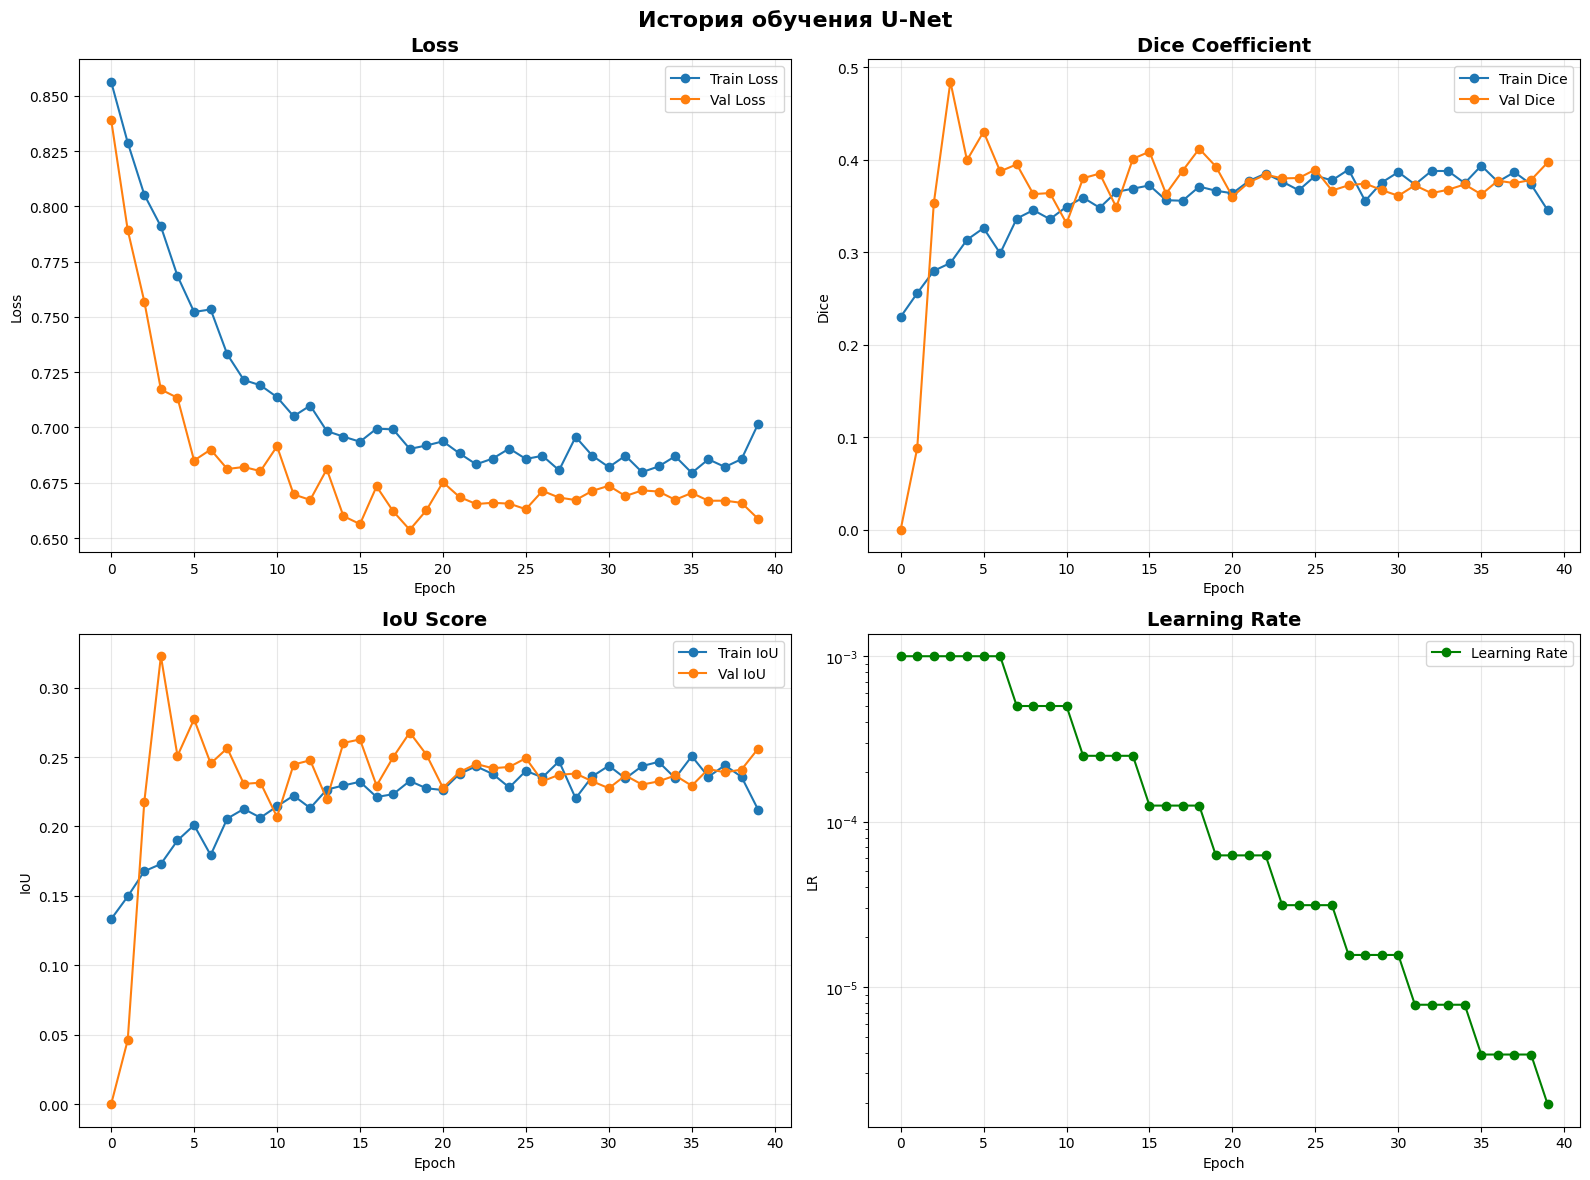

Train Loss: 0.7016
Val Loss: 0.6587
Train Dice: 0.3454
Val Dice: 0.3970
Train IoU: 0.2120
Val IoU: 0.2561
Val Accuracy: 0.8992


In [73]:
plot_training_history(history)


## Визуализация предсказаний модели


In [74]:
def visualize_predictions(model, dataloader, device, num_samples=4):

    model.eval()
    model.to(device)
    images_list = []
    masks_list = []

    for images, masks in dataloader:
        images_list.append(images)
        masks_list.append(masks)
        if sum(len(b) for b in images_list) >= num_samples:
            break
    images = torch.cat(images_list, dim=0)[:num_samples]
    masks = torch.cat(masks_list, dim=0)[:num_samples]

    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        predictions = model(images)
        predictions = (predictions > 0.5).float()

    images = images.cpu()
    masks = masks.cpu()
    predictions = predictions.cpu()

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if min(num_samples, len(images)) == 1:
        axes = axes.reshape(1, -1)

    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        mask_true = masks[i, :,:].numpy()
        mask_pred = predictions[i, 0].numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное изображение', fontsize=12)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Истинная маска', fontsize=12)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(mask_pred, cmap='gray')
        axes[i, 2].set_title('Предсказание', fontsize=12)
        axes[i, 2].axis('off')

        overlay = img.copy()
        overlay[mask_pred > 0.5] = [0, 1, 0]

        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title('Наложение', fontsize=12)
        axes[i, 3].axis('off')

        dice = dice_coefficient(predictions[i:i+1], masks[i:i+1])
        iou = iou_score(predictions[i:i+1], masks[i:i+1])


        axes[i, 3].text(
            0.5, -0.15,
            f'Dice: {dice:.4f}   |   IoU: {iou:.4f}',
            transform=axes[i, 3].transAxes,
            ha='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", edgecolor="none")
        )

    plt.suptitle('Предсказания модели U-Net', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

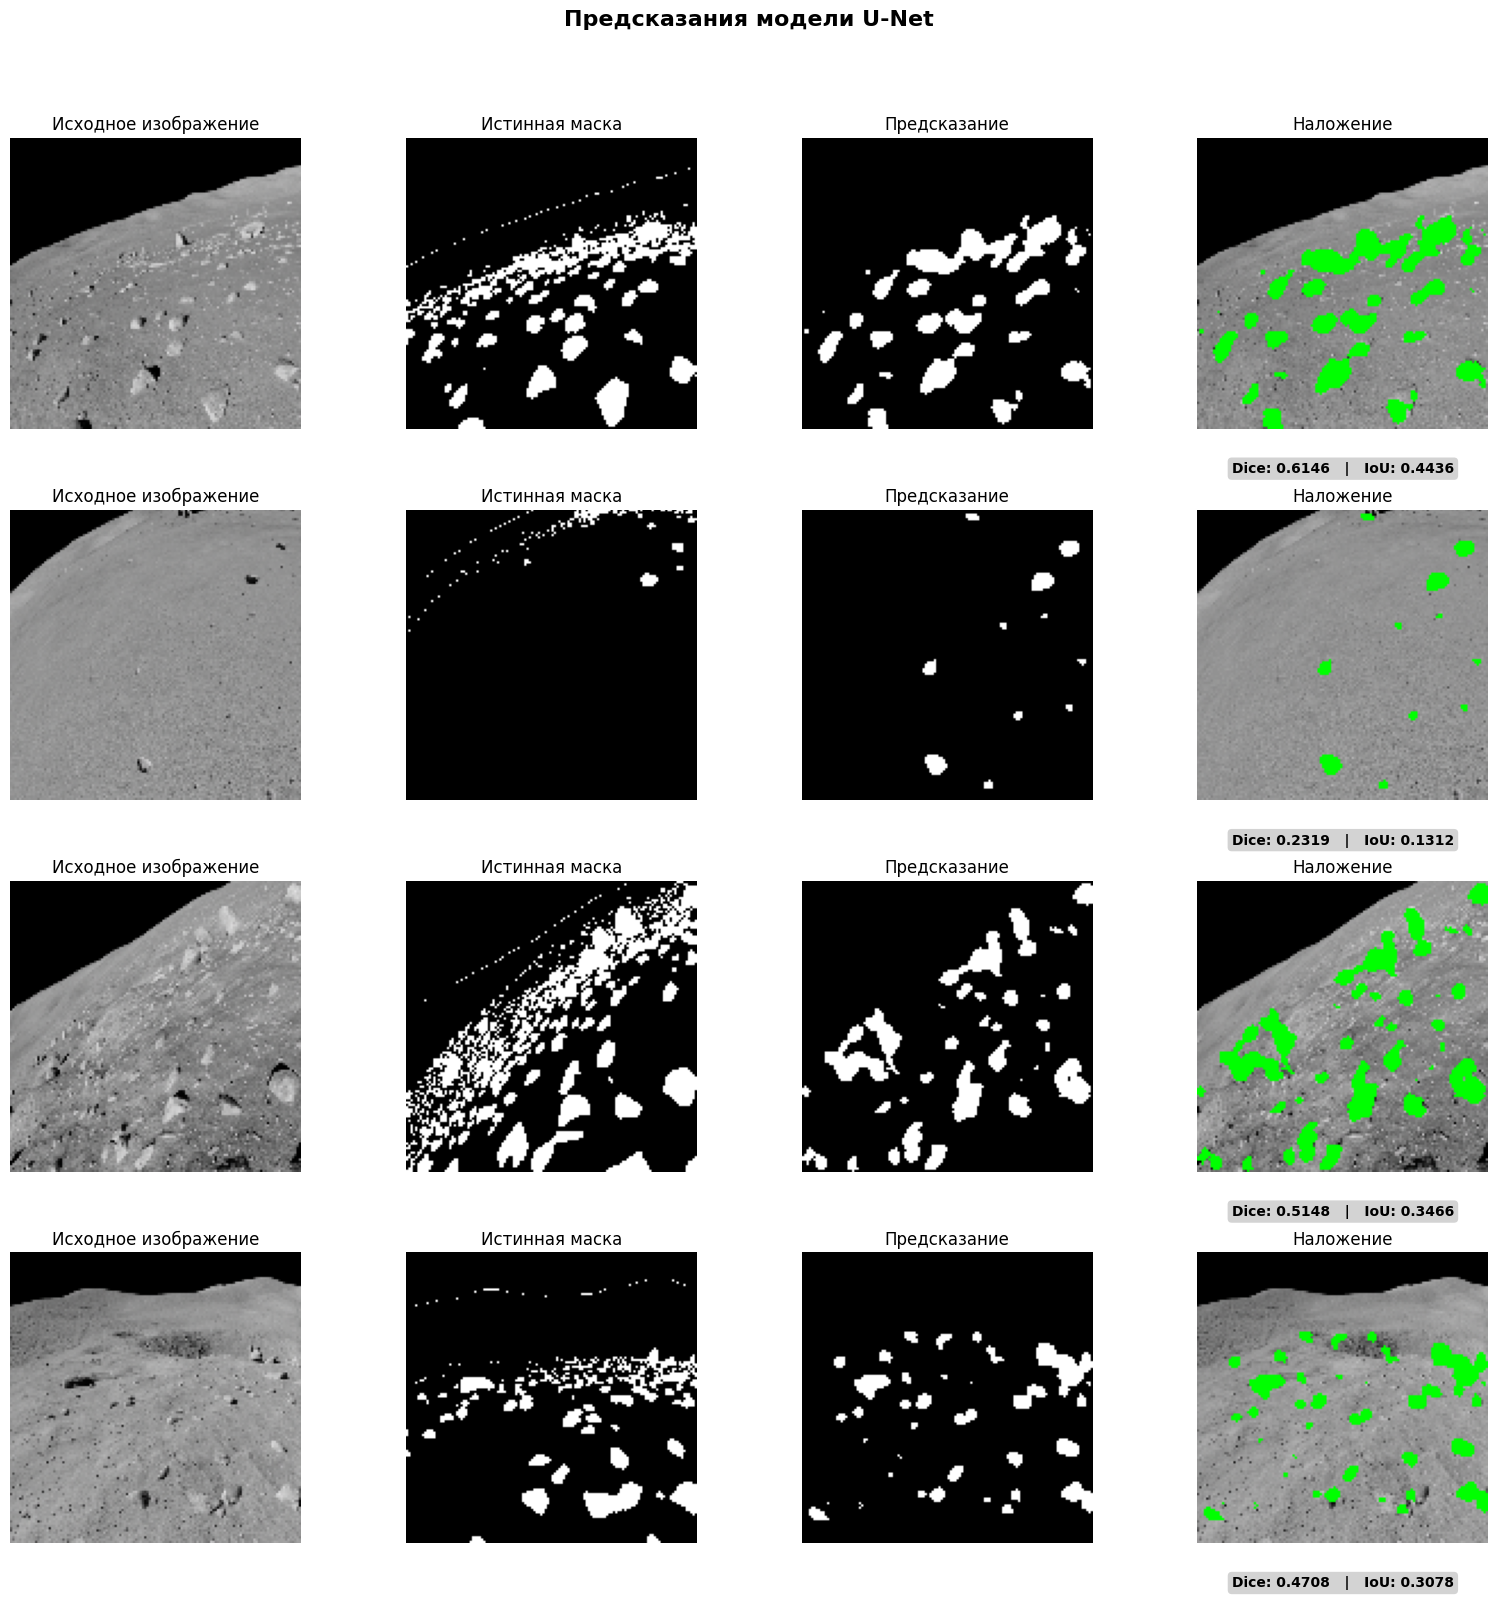

In [75]:
visualize_predictions(model, val_loader, device, num_samples=4)

## Загрузка и тестирование лучшей модели


Параметров: 1,934,306
Encoder уровней: 4
Каналы: [32, 64, 128, 256]
Эпоха: 4
Val Dice: 0.4843
Val IoU: 0.3226


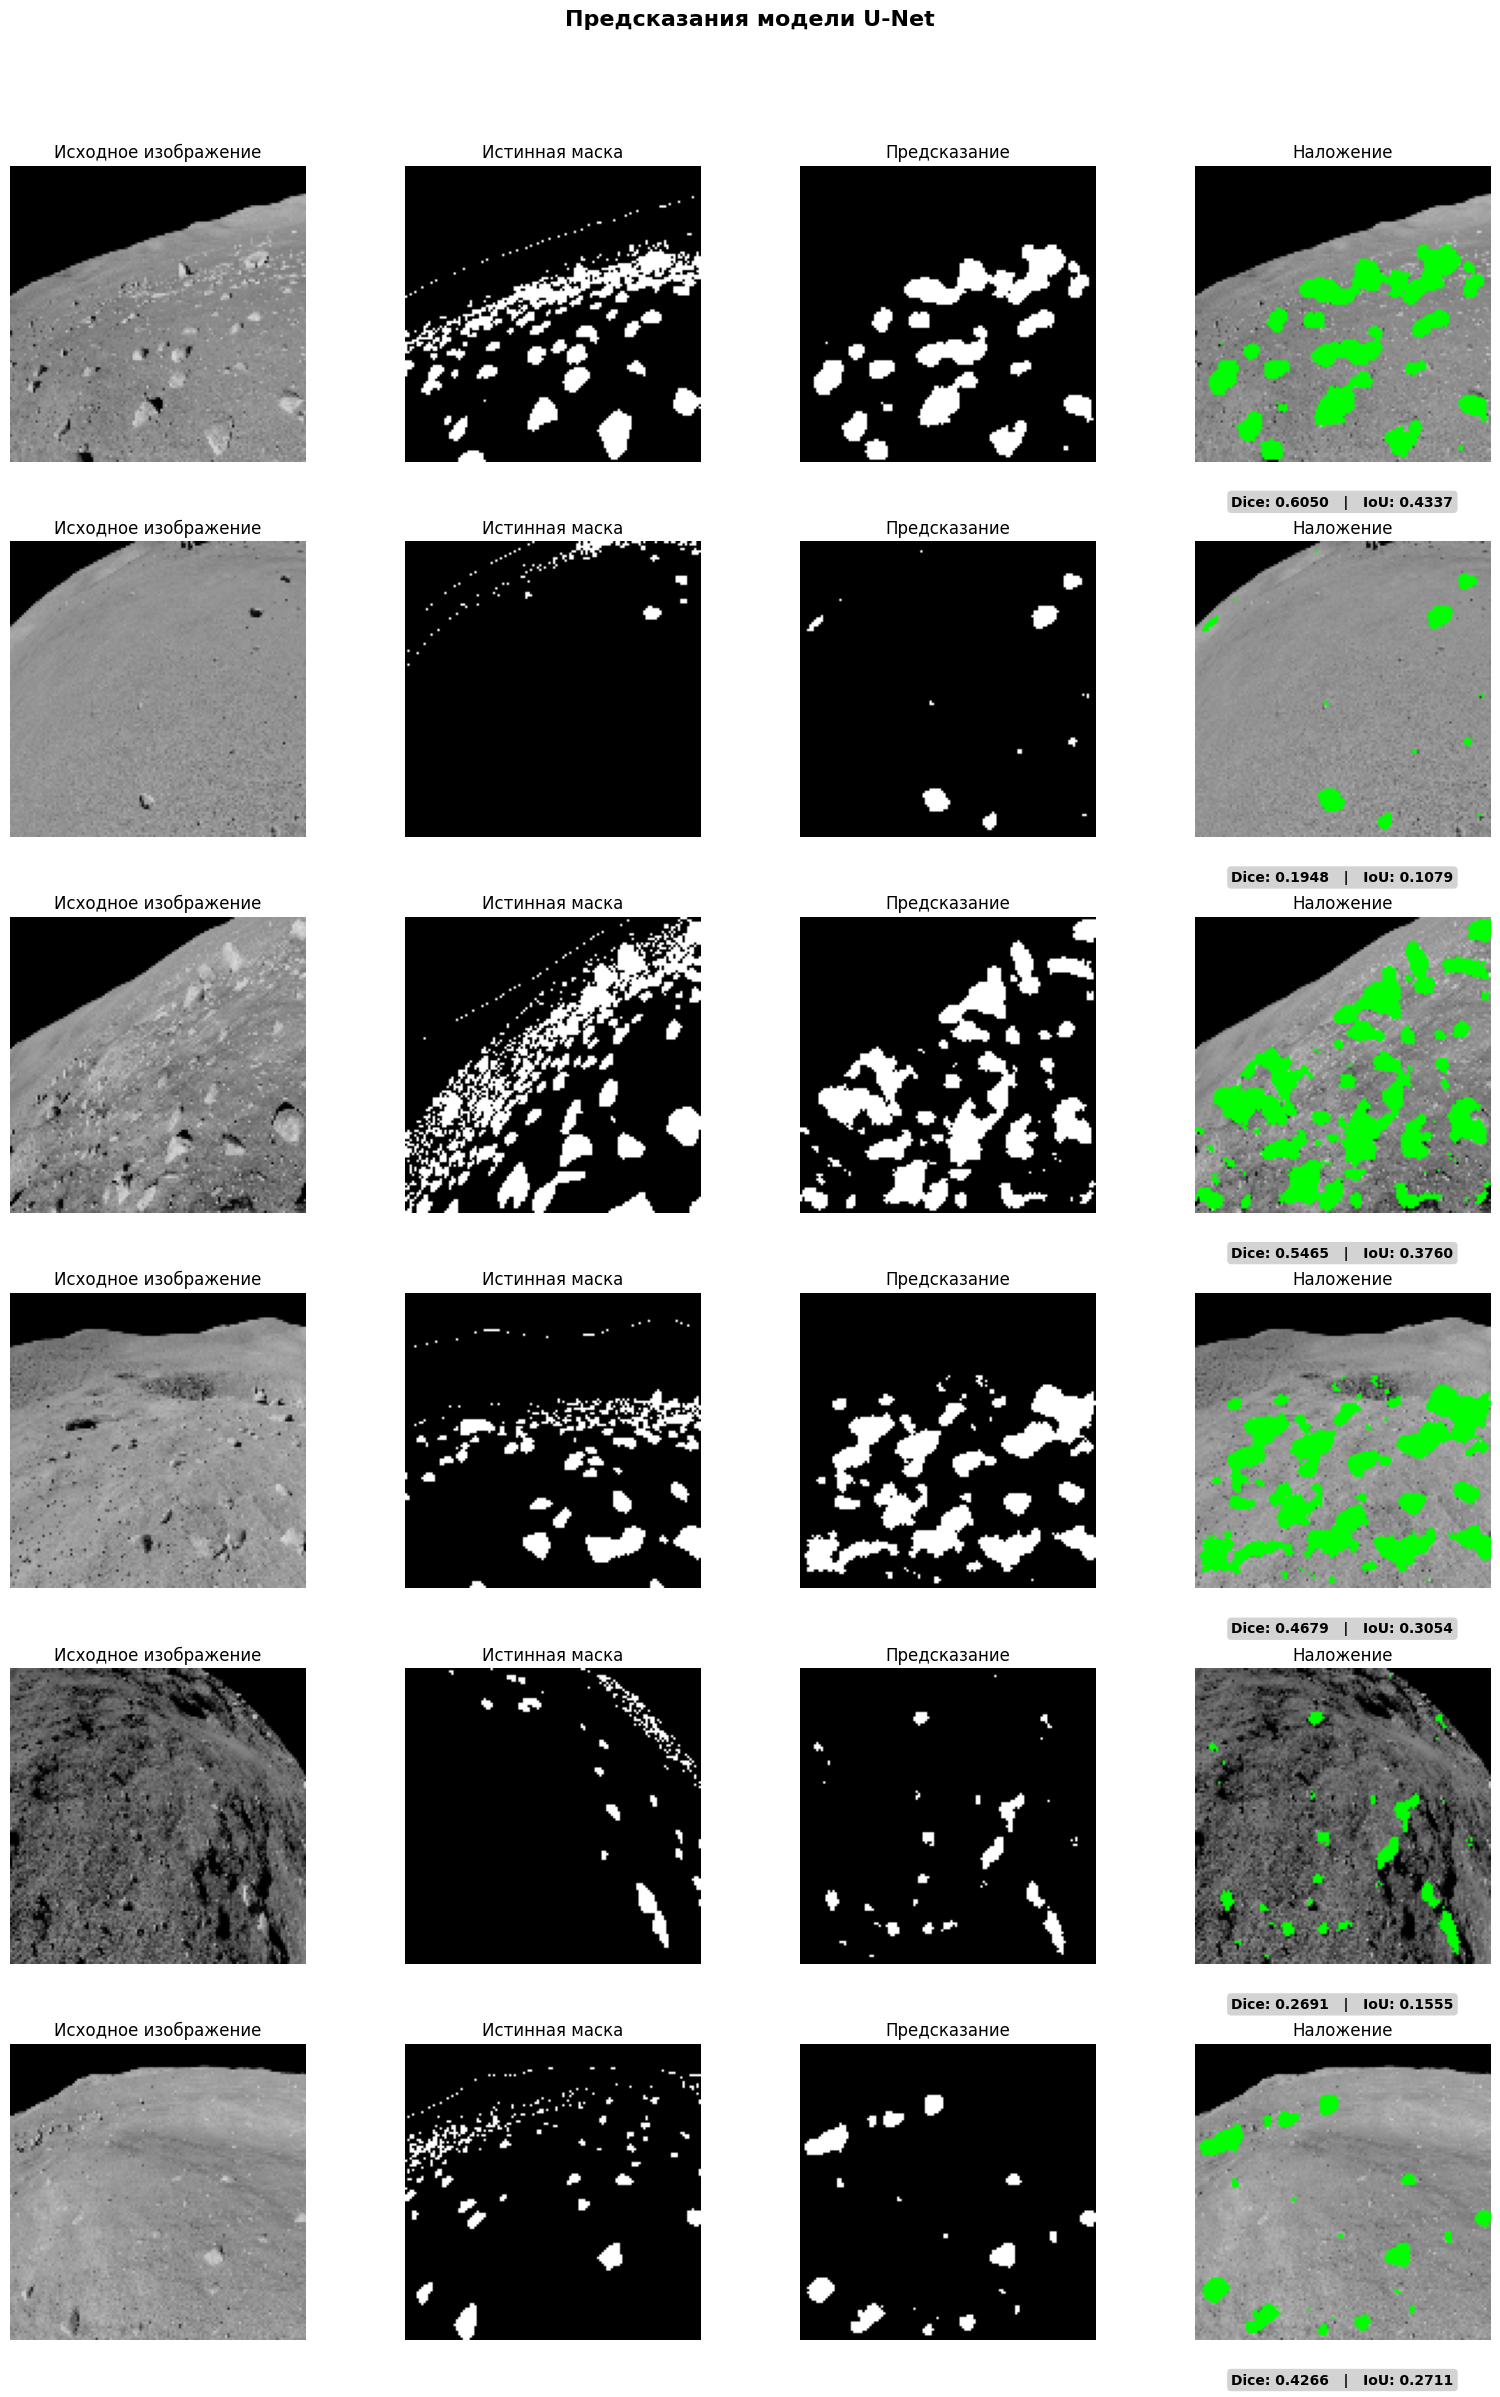

In [77]:
best_model_unet = UNet(in_channels=3, out_channels=1, features=[32, 64, 128, 256])

checkpoint = torch.load('best_moon_unet.pth', map_location=device)
best_model_unet.load_state_dict(checkpoint['model_state_dict'])
best_model_unet = best_model_unet.to(device)

print(f"Эпоха: {checkpoint['epoch'] + 1}")
print(f"Val Dice: {checkpoint['val_dice']:.4f}")
print(f"Val IoU: {checkpoint['val_iou']:.4f}")

visualize_predictions(best_model_unet, val_loader, device, num_samples=6)


# Часть 3. U-Net с бэкбоном из классификатора

In [78]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()

        self.block = nn.Sequential(
            # Depthwise
            nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1,
                      groups=in_channels, bias=False),
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),

            # Pointwise
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Dropout2d(dropout)
        )

    def forward(self, x):
        return self.block(x)


In [79]:
class UNetWithCustomCNNBackbone(nn.Module):
    def __init__(
        self,
        backbone: CustomCNN,
        out_channels=1,
        freeze_encoder=True
    ):
        super().__init__()
        self.encoder = backbone

        # ===== Freeze encoder (вариант A) =====
        if freeze_encoder:
            for p in self.encoder.parameters():
                p.requires_grad = False

        # ===== Encoder channels from CustomCNN =====
        # skip1: 128×128 → 64
        # skip2: 128×128 → 64
        # skip3: 64×64   → 128
        # skip4: 32×32   → 256
        enc_channels = [64, 64, 128, 256]

        # ===== Bottleneck (как в базовой UNet) =====
        self.bottleneck = DoubleConvDS(
            enc_channels[-1],
            enc_channels[-1] * 2  # 256 → 512
        )

        # ===== Decoder (полностью повторяет твою UNet) =====
        self.decoder_blocks = nn.ModuleList()

        decoder_in = enc_channels[-1] * 2  # 512

        for skip_ch in reversed(enc_channels):
            self.decoder_blocks.append(
                nn.ConvTranspose2d(
                    decoder_in, skip_ch,
                    kernel_size=2, stride=2
                )
            )
            self.decoder_blocks.append(
                DoubleConvDS(
                    skip_ch * 2,
                    skip_ch
                )
            )
            decoder_in = skip_ch

        # ===== Final =====
        self.final_conv = nn.Sequential(
            nn.Conv2d(enc_channels[0], out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        input_size = x.shape[2:]
        skips = []

        # ===== Encoder (CustomCNN) =====
        x = self.encoder.activation(self.encoder.bn1(self.encoder.conv1(x)))
        x = self.encoder.maxpool(x)
        skips.append(x)                 # 128×128, 64

        x = self.encoder.block1_1(x)
        x = self.encoder.block1_2(x)
        skips.append(x)                 # 128×128, 64

        x = self.encoder.block2_1(x)
        x = self.encoder.block2_2(x)
        skips.append(x)                 # 64×64, 128

        x = self.encoder.block3_1(x)
        x = self.encoder.block3_2(x)
        skips.append(x)                 # 32×32, 256

        # ===== Bottleneck =====
        x = self.bottleneck(x)          # 16×16, 512
        skips = skips[::-1]

        # ===== Decoder =====
        for idx in range(0, len(self.decoder_blocks), 2):
            x = self.decoder_blocks[idx](x)
            skip = skips[idx // 2]

            if x.shape[2:] != skip.shape[2:]:
                x = F.interpolate(
                    x,
                    size=skip.shape[2:],
                    mode="bilinear",
                    align_corners=False
                )

            x = torch.cat([skip, x], dim=1)
            x = self.decoder_blocks[idx + 1](x)

        x = self.final_conv(x)

        # ===== Restore input resolution =====
        if x.shape[2:] != input_size:
            x = F.interpolate(
                x,
                size=input_size,
                mode="bilinear",
                align_corners=False
            )

        return x


In [80]:
classifier = CustomCNN(num_classes=10).to(device)

classifier.load_state_dict(
    torch.load("/kaggle/input/weights-resnet/CNN_tiny_imagenet_model.pth", map_location=device)
)
classifier.eval()


resnet_unetA = UNetWithCustomCNNBackbone(
    backbone=classifier,
    out_channels=1,
    freeze_encoder=True
).to(device)


In [81]:
test_input = torch.randn(1, 3, 256, 256).to(device)
test_output = resnet_unetA(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

total_params = sum(p.numel() for p in resnet_unetA.parameters())
trainable_params = sum(p.numel() for p in resnet_unetA.parameters() if p.requires_grad)

print(f"   Всего параметров: {total_params:,}")
print(f"   Обучаемых параметров: {trainable_params:,}")

   Вход:  torch.Size([1, 3, 256, 256])
   Выход: torch.Size([1, 1, 256, 256])
   Всего параметров: 3,810,187
   Обучаемых параметров: 1,032,513


In [47]:
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(resnet_unetA.parameters(), lr=1e-4, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3,
)

NUM_EPOCHS_RESNET = 40
SAVE_PATH_RESNET = 'best_resnet18_unet_A.pth'

In [48]:
resnet_history_A = train_model(
    model=resnet_unetA,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS_RESNET,
    device=device,
    save_path=SAVE_PATH_RESNET
)


Эпоха 1/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.08it/s, loss=0.7616, dice=0.2970, iou=0.1744, acc=0.7488]



 Результаты эпохи 1:
  Train - Loss: 0.8777, Dice: 0.1822, IoU: 0.1019
  Val   - Loss: 0.8515, Dice: 0.2333, IoU: 0.1339, Acc: 0.8528
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.2333
Эпоха 2/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.82it/s, loss=0.7484, dice=0.3847, iou=0.2382, acc=0.7590]



 Результаты эпохи 2:
  Train - Loss: 0.8646, Dice: 0.2379, IoU: 0.1379
  Val   - Loss: 0.8330, Dice: 0.3201, IoU: 0.1935, Acc: 0.8556
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3201
Эпоха 3/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.25it/s, loss=0.7321, dice=0.4684, iou=0.3058, acc=0.6860]



 Результаты эпохи 3:
  Train - Loss: 0.8532, Dice: 0.2726, IoU: 0.1593
  Val   - Loss: 0.8168, Dice: 0.3486, IoU: 0.2149, Acc: 0.7859
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3486
Эпоха 4/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.00it/s, loss=0.7185, dice=0.4840, iou=0.3192, acc=0.6789]



 Результаты эпохи 4:
  Train - Loss: 0.8422, Dice: 0.2878, IoU: 0.1709
  Val   - Loss: 0.8038, Dice: 0.3602, IoU: 0.2233, Acc: 0.7767
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3602
Эпоха 5/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.13it/s, loss=0.7094, dice=0.4852, iou=0.3203, acc=0.7203]



 Результаты эпохи 5:
  Train - Loss: 0.8317, Dice: 0.3004, IoU: 0.1825
  Val   - Loss: 0.7924, Dice: 0.3704, IoU: 0.2312, Acc: 0.8058
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3704
Эпоха 6/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.54it/s, loss=0.6991, dice=0.4933, iou=0.3274, acc=0.6857]



 Результаты эпохи 6:
  Train - Loss: 0.8240, Dice: 0.3100, IoU: 0.1867
  Val   - Loss: 0.7817, Dice: 0.3833, IoU: 0.2400, Acc: 0.7782
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3833
Эпоха 7/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.15it/s, loss=0.6866, dice=0.5105, iou=0.3428, acc=0.7420]



 Результаты эпохи 7:
  Train - Loss: 0.8159, Dice: 0.3137, IoU: 0.1902
  Val   - Loss: 0.7691, Dice: 0.3974, IoU: 0.2514, Acc: 0.8187
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3974
Эпоха 8/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.91it/s, loss=0.6792, dice=0.5090, iou=0.3414, acc=0.7619]



 Результаты эпохи 8:
  Train - Loss: 0.8113, Dice: 0.3192, IoU: 0.1946
  Val   - Loss: 0.7602, Dice: 0.4128, IoU: 0.2634, Acc: 0.8354
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4128
Эпоха 9/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.51it/s, loss=0.6697, dice=0.5299, iou=0.3605, acc=0.7309]



 Результаты эпохи 9:
  Train - Loss: 0.8037, Dice: 0.3291, IoU: 0.2014
  Val   - Loss: 0.7562, Dice: 0.4108, IoU: 0.2620, Acc: 0.8067
  LR: 0.000100
Эпоха 10/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s, loss=0.6704, dice=0.5144, iou=0.3463, acc=0.7607]



 Результаты эпохи 10:
  Train - Loss: 0.7978, Dice: 0.3421, IoU: 0.2102
  Val   - Loss: 0.7504, Dice: 0.4202, IoU: 0.2696, Acc: 0.8384
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4202
Эпоха 11/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.80it/s, loss=0.6631, dice=0.5272, iou=0.3579, acc=0.7583]



 Результаты эпохи 11:
  Train - Loss: 0.7900, Dice: 0.3548, IoU: 0.2190
  Val   - Loss: 0.7460, Dice: 0.4245, IoU: 0.2727, Acc: 0.8349
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4245
Эпоха 12/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.32it/s, loss=0.6616, dice=0.5195, iou=0.3509, acc=0.7706]



 Результаты эпохи 12:
  Train - Loss: 0.7923, Dice: 0.3399, IoU: 0.2104
  Val   - Loss: 0.7397, Dice: 0.4358, IoU: 0.2815, Acc: 0.8509
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4358
Эпоха 13/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.23it/s, loss=0.6637, dice=0.5206, iou=0.3519, acc=0.7263]



 Результаты эпохи 13:
  Train - Loss: 0.7796, Dice: 0.3722, IoU: 0.2323
  Val   - Loss: 0.7412, Dice: 0.4189, IoU: 0.2682, Acc: 0.8188
  LR: 0.000100
Эпоха 14/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.88it/s, loss=0.6595, dice=0.5139, iou=0.3458, acc=0.7539]



 Результаты эпохи 14:
  Train - Loss: 0.7723, Dice: 0.3808, IoU: 0.2407
  Val   - Loss: 0.7363, Dice: 0.4163, IoU: 0.2668, Acc: 0.8403
  LR: 0.000100
Эпоха 15/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.61it/s, loss=0.6604, dice=0.5154, iou=0.3471, acc=0.7439]



 Результаты эпохи 15:
  Train - Loss: 0.7724, Dice: 0.3781, IoU: 0.2375
  Val   - Loss: 0.7383, Dice: 0.4076, IoU: 0.2606, Acc: 0.8309
  LR: 0.000100
Эпоха 16/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.49it/s, loss=0.6512, dice=0.5255, iou=0.3563, acc=0.7746]



 Результаты эпохи 16:
  Train - Loss: 0.7723, Dice: 0.3670, IoU: 0.2315
  Val   - Loss: 0.7291, Dice: 0.4264, IoU: 0.2754, Acc: 0.8541
  LR: 0.000050
Эпоха 17/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.28it/s, loss=0.6505, dice=0.5182, iou=0.3497, acc=0.7808]



 Результаты эпохи 17:
  Train - Loss: 0.7640, Dice: 0.3938, IoU: 0.2533
  Val   - Loss: 0.7261, Dice: 0.4298, IoU: 0.2777, Acc: 0.8605
  LR: 0.000050
Эпоха 18/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.14it/s, loss=0.6499, dice=0.5288, iou=0.3595, acc=0.7600]



 Результаты эпохи 18:
  Train - Loss: 0.7616, Dice: 0.3952, IoU: 0.2511
  Val   - Loss: 0.7278, Dice: 0.4265, IoU: 0.2753, Acc: 0.8372
  LR: 0.000050
Эпоха 19/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.36it/s, loss=0.6476, dice=0.5204, iou=0.3517, acc=0.7764]



 Результаты эпохи 19:
  Train - Loss: 0.7645, Dice: 0.3774, IoU: 0.2363
  Val   - Loss: 0.7234, Dice: 0.4380, IoU: 0.2839, Acc: 0.8533
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4380
Эпоха 20/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.20it/s, loss=0.6468, dice=0.5283, iou=0.3589, acc=0.7734]



 Результаты эпохи 20:
  Train - Loss: 0.7605, Dice: 0.3877, IoU: 0.2469
  Val   - Loss: 0.7249, Dice: 0.4360, IoU: 0.2824, Acc: 0.8498
  LR: 0.000050
Эпоха 21/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.81it/s, loss=0.6436, dice=0.5325, iou=0.3629, acc=0.7730]



 Результаты эпохи 21:
  Train - Loss: 0.7530, Dice: 0.4099, IoU: 0.2643
  Val   - Loss: 0.7214, Dice: 0.4410, IoU: 0.2866, Acc: 0.8502
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4410
Эпоха 22/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.01it/s, loss=0.6390, dice=0.5341, iou=0.3644, acc=0.7843]



 Результаты эпохи 22:
  Train - Loss: 0.7558, Dice: 0.3905, IoU: 0.2498
  Val   - Loss: 0.7164, Dice: 0.4442, IoU: 0.2893, Acc: 0.8615
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.4442
Эпоха 23/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.15it/s, loss=0.6407, dice=0.5332, iou=0.3636, acc=0.7763]



 Результаты эпохи 23:
  Train - Loss: 0.7536, Dice: 0.3934, IoU: 0.2510
  Val   - Loss: 0.7176, Dice: 0.4436, IoU: 0.2886, Acc: 0.8530
  LR: 0.000050
Эпоха 24/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.77it/s, loss=0.6372, dice=0.5322, iou=0.3626, acc=0.7856]



 Результаты эпохи 24:
  Train - Loss: 0.7503, Dice: 0.4049, IoU: 0.2615
  Val   - Loss: 0.7132, Dice: 0.4416, IoU: 0.2871, Acc: 0.8627
  LR: 0.000050
Эпоха 25/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.92it/s, loss=0.6373, dice=0.5431, iou=0.3728, acc=0.7756]



 Результаты эпохи 25:
  Train - Loss: 0.7418, Dice: 0.4196, IoU: 0.2699
  Val   - Loss: 0.7150, Dice: 0.4427, IoU: 0.2882, Acc: 0.8541
  LR: 0.000050
Эпоха 26/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.29it/s, loss=0.6353, dice=0.5312, iou=0.3617, acc=0.7819]



 Результаты эпохи 26:
  Train - Loss: 0.7468, Dice: 0.3992, IoU: 0.2548
  Val   - Loss: 0.7113, Dice: 0.4393, IoU: 0.2856, Acc: 0.8595
  LR: 0.000025
Эпоха 27/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.25it/s, loss=0.6323, dice=0.5413, iou=0.3711, acc=0.7828]



 Результаты эпохи 27:
  Train - Loss: 0.7416, Dice: 0.4173, IoU: 0.2686
  Val   - Loss: 0.7101, Dice: 0.4421, IoU: 0.2879, Acc: 0.8565
  LR: 0.000025
Эпоха 28/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.47it/s, loss=0.6345, dice=0.5379, iou=0.3679, acc=0.7858]



 Результаты эпохи 28:
  Train - Loss: 0.7424, Dice: 0.4096, IoU: 0.2640
  Val   - Loss: 0.7107, Dice: 0.4428, IoU: 0.2884, Acc: 0.8613
  LR: 0.000025
Эпоха 29/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.10it/s, loss=0.6358, dice=0.5350, iou=0.3652, acc=0.7779]



 Результаты эпохи 29:
  Train - Loss: 0.7422, Dice: 0.4131, IoU: 0.2664
  Val   - Loss: 0.7107, Dice: 0.4434, IoU: 0.2887, Acc: 0.8563
  LR: 0.000025
Эпоха 30/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.26it/s, loss=0.6324, dice=0.5408, iou=0.3706, acc=0.7837]



 Результаты эпохи 30:
  Train - Loss: 0.7393, Dice: 0.4192, IoU: 0.2713
  Val   - Loss: 0.7097, Dice: 0.4427, IoU: 0.2884, Acc: 0.8579
  LR: 0.000013
Эпоха 31/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.77it/s, loss=0.6322, dice=0.5365, iou=0.3666, acc=0.7845]



 Результаты эпохи 31:
  Train - Loss: 0.7465, Dice: 0.3990, IoU: 0.2557
  Val   - Loss: 0.7089, Dice: 0.4383, IoU: 0.2851, Acc: 0.8603
  LR: 0.000013
Эпоха 32/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.73it/s, loss=0.6320, dice=0.5367, iou=0.3668, acc=0.7846]



 Результаты эпохи 32:
  Train - Loss: 0.7373, Dice: 0.4207, IoU: 0.2710
  Val   - Loss: 0.7086, Dice: 0.4422, IoU: 0.2879, Acc: 0.8607
  LR: 0.000013
Эпоха 33/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.48it/s, loss=0.6310, dice=0.5441, iou=0.3737, acc=0.7757]



 Результаты эпохи 33:
  Train - Loss: 0.7493, Dice: 0.3933, IoU: 0.2522
  Val   - Loss: 0.7087, Dice: 0.4405, IoU: 0.2868, Acc: 0.8516
  LR: 0.000013
Эпоха 34/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.89it/s, loss=0.6326, dice=0.5286, iou=0.3593, acc=0.7896]



 Результаты эпохи 34:
  Train - Loss: 0.7336, Dice: 0.4298, IoU: 0.2773
  Val   - Loss: 0.7071, Dice: 0.4421, IoU: 0.2879, Acc: 0.8665
  LR: 0.000006
Эпоха 35/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.00it/s, loss=0.6310, dice=0.5325, iou=0.3629, acc=0.7907]



 Результаты эпохи 35:
  Train - Loss: 0.7490, Dice: 0.3884, IoU: 0.2494
  Val   - Loss: 0.7063, Dice: 0.4437, IoU: 0.2894, Acc: 0.8684
  LR: 0.000006
Эпоха 36/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.00it/s, loss=0.6305, dice=0.5364, iou=0.3665, acc=0.7883]



 Результаты эпохи 36:
  Train - Loss: 0.7364, Dice: 0.4172, IoU: 0.2719
  Val   - Loss: 0.7061, Dice: 0.4459, IoU: 0.2909, Acc: 0.8649
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.4459
Эпоха 37/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 14.13it/s, loss=0.6319, dice=0.5295, iou=0.3600, acc=0.7884]



 Результаты эпохи 37:
  Train - Loss: 0.7403, Dice: 0.4126, IoU: 0.2644
  Val   - Loss: 0.7055, Dice: 0.4487, IoU: 0.2928, Acc: 0.8667
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.4487
Эпоха 38/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.00it/s, loss=0.6321, dice=0.5321, iou=0.3625, acc=0.7888]



 Результаты эпохи 38:
  Train - Loss: 0.7353, Dice: 0.4274, IoU: 0.2777
  Val   - Loss: 0.7070, Dice: 0.4495, IoU: 0.2934, Acc: 0.8654
  LR: 0.000006
  Сохранена лучшая модель! Dice: 0.4495
Эпоха 39/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.48it/s, loss=0.6319, dice=0.5381, iou=0.3681, acc=0.7764]



 Результаты эпохи 39:
  Train - Loss: 0.7385, Dice: 0.4133, IoU: 0.2653
  Val   - Loss: 0.7076, Dice: 0.4487, IoU: 0.2928, Acc: 0.8542
  LR: 0.000006
Эпоха 40/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.95it/s, loss=0.6304, dice=0.5385, iou=0.3685, acc=0.7797]


 Результаты эпохи 40:
  Train - Loss: 0.7302, Dice: 0.4359, IoU: 0.2856
  Val   - Loss: 0.7058, Dice: 0.4478, IoU: 0.2919, Acc: 0.8564
  LR: 0.000006
Лучший Val Dice: 0.4495


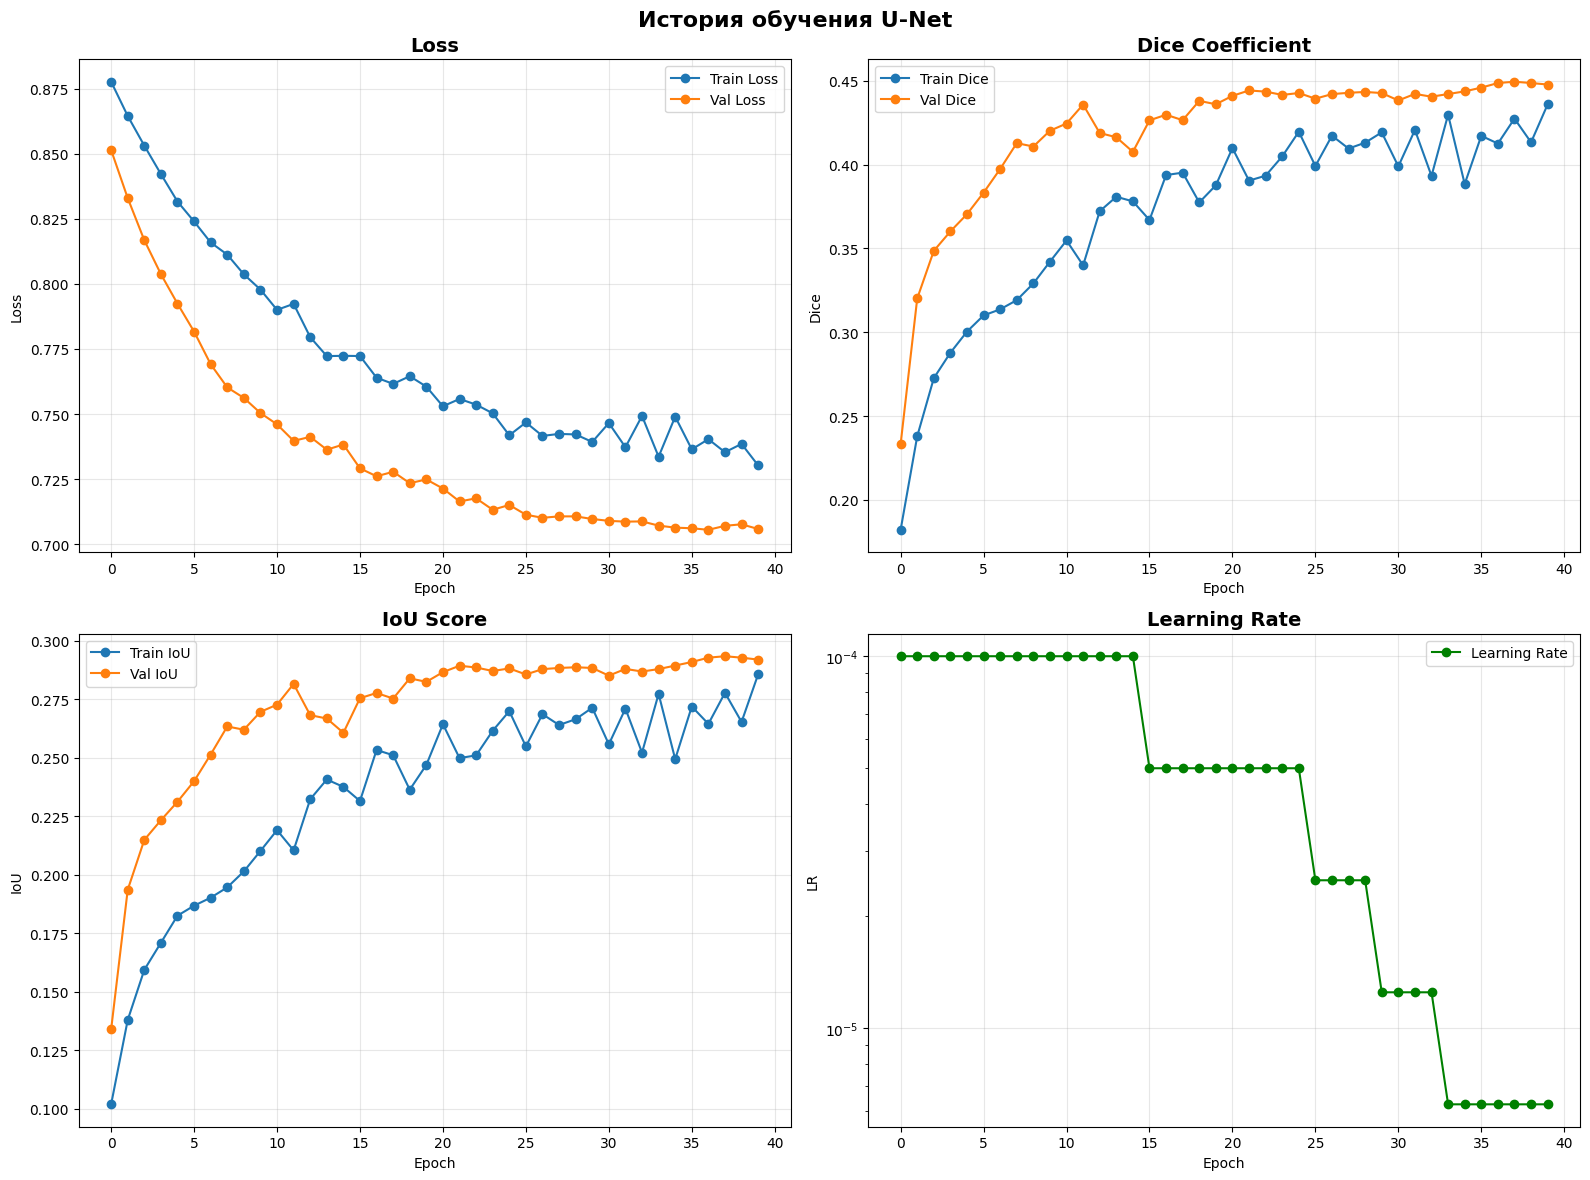

Train Loss: 0.7302
Val Loss: 0.7058
Train Dice: 0.4359
Val Dice: 0.4478
Train IoU: 0.2856
Val IoU: 0.2919
Val Accuracy: 0.8564


In [49]:
plot_training_history(resnet_history_A)


In [51]:
best_resnet_unetA = UNetWithCustomCNNBackbone(
    backbone=classifier,
    out_channels=1,
    freeze_encoder=True
).to(device)

checkpoint = torch.load('/kaggle/working/best_resnet18_unet_A.pth', map_location=device)
best_resnet_unetA.load_state_dict(checkpoint['model_state_dict'])
best_resnet_unetA = best_resnet_unetA.to(device)

print(f"   Best epoch: {checkpoint['epoch']}")
print(f"   Best val Dice: {checkpoint['val_dice']:.4f}")


   Best epoch: 37
   Best val Dice: 0.4495


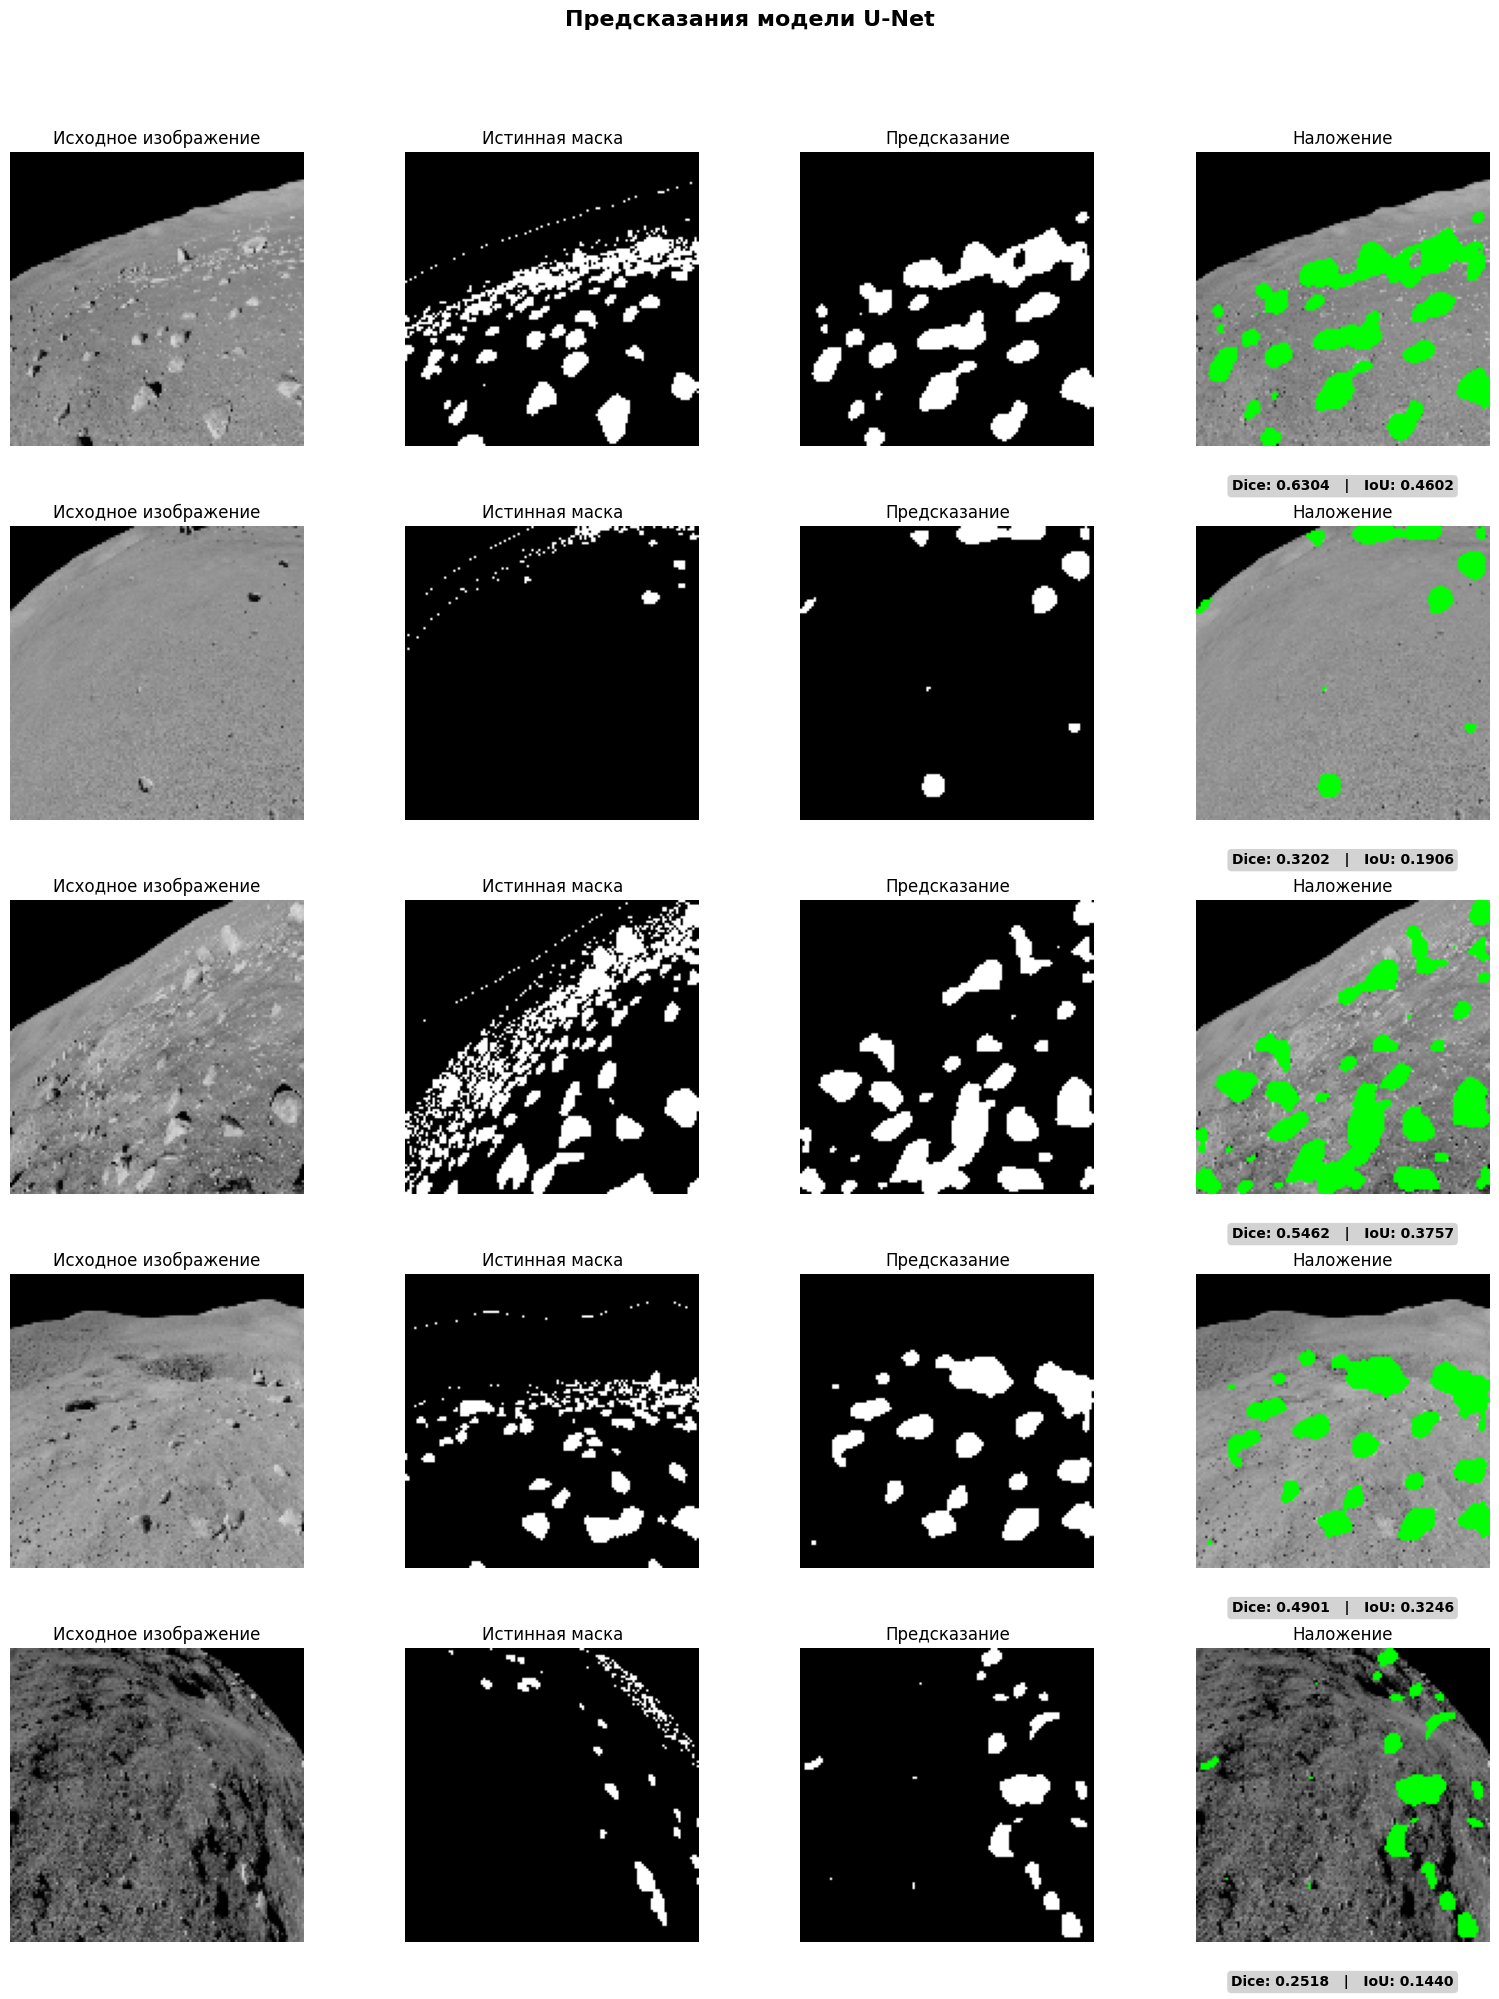

In [54]:
visualize_predictions(best_resnet_unetA, val_loader, device, num_samples=5)


# B. Finetune

In [57]:
classifier = CustomCNN(num_classes=10).to(device)

classifier.load_state_dict(
    torch.load("/kaggle/input/weights-resnet/CNN_tiny_imagenet_model.pth", map_location=device)
)
classifier.eval()


resnet_unetB = UNetWithCustomCNNBackbone(
    backbone=classifier,
    out_channels=1,
    freeze_encoder=False
).to(device)


test_input = torch.randn(1, 3, 256, 256).to(device)
test_output = resnet_unetB(test_input)

print(f"   Вход:  {test_input.shape}")
print(f"   Выход: {test_output.shape}")

total_params = sum(p.numel() for p in resnet_unetB.parameters())
trainable_params = sum(p.numel() for p in resnet_unetB.parameters() if p.requires_grad)

print(f"   Всего параметров: {total_params:,}")
print(f"   Обучаемых параметров: {trainable_params:,}")


resnet_criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)

# Разделяем параметры на encoder (ResNet) и decoder
encoder_params = []
decoder_params = []

for name, param in resnet_unetB.named_parameters():
    if 'encoder' in name:
        encoder_params.append(param)
    else:
        decoder_params.append(param)

# Encoder обучаем с меньшим LR (fine-tuning), decoder - с обычным
resnet_optimizer = torch.optim.Adam([
    {'params': encoder_params, 'lr': 1e-4},  # Меньший LR для предобученных слоев
    {'params': decoder_params, 'lr': 1e-3}   # Обычный LR для новых слоев
])

resnet_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    resnet_optimizer, 
    mode='min', 
    factor=0.5, 
    patience=5, 
)

NUM_EPOCHS_RESNET = 40
SAVE_PATH_RESNET = 'best_resnet18_unet_B.pth'

print(f"   Эпох: {NUM_EPOCHS_RESNET}")
print(f"   Encoder LR: 1e-4 (fine-tuning)")
print(f"   Decoder LR: 1e-3")
print(f"   Модель будет сохранена в: {SAVE_PATH_RESNET}")

   Вход:  torch.Size([1, 3, 256, 256])
   Выход: torch.Size([1, 1, 256, 256])
   Всего параметров: 3,810,187
   Обучаемых параметров: 3,810,187
   Эпох: 40
   Encoder LR: 1e-4 (fine-tuning)
   Decoder LR: 1e-3
   Модель будет сохранена в: best_resnet18_unet_B.pth


In [58]:
resnet_history = train_model(
    model=resnet_unetB,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=resnet_criterion,
    optimizer=resnet_optimizer,
    scheduler=resnet_scheduler,
    num_epochs=NUM_EPOCHS_RESNET,
    device=device,
    save_path=SAVE_PATH_RESNET
)


Эпоха 1/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.86it/s, loss=0.7307, dice=0.4242, iou=0.2692, acc=0.7492]



 Результаты эпохи 1:
  Train - Loss: 0.8467, Dice: 0.2604, IoU: 0.1536
  Val   - Loss: 0.8136, Dice: 0.3473, IoU: 0.2133, Acc: 0.8319
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.3473
Эпоха 2/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.59it/s, loss=0.6660, dice=0.4793, iou=0.3152, acc=0.7571]



 Результаты эпохи 2:
  Train - Loss: 0.7917, Dice: 0.3193, IoU: 0.1931
  Val   - Loss: 0.7340, Dice: 0.4120, IoU: 0.2616, Acc: 0.8417
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4120
Эпоха 3/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.69it/s, loss=0.6389, dice=0.5239, iou=0.3549, acc=0.7528]



 Результаты эпохи 3:
  Train - Loss: 0.7607, Dice: 0.3542, IoU: 0.2204
  Val   - Loss: 0.7009, Dice: 0.4653, IoU: 0.3043, Acc: 0.8439
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4653
Эпоха 4/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.54it/s, loss=0.6196, dice=0.5371, iou=0.3671, acc=0.7839]



 Результаты эпохи 4:
  Train - Loss: 0.7352, Dice: 0.3719, IoU: 0.2342
  Val   - Loss: 0.6847, Dice: 0.4433, IoU: 0.2890, Acc: 0.8631
  LR: 0.000100
Эпоха 5/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.58it/s, loss=0.5929, dice=0.5624, iou=0.3912, acc=0.8117]



 Результаты эпохи 5:
  Train - Loss: 0.7177, Dice: 0.3796, IoU: 0.2397
  Val   - Loss: 0.6579, Dice: 0.4742, IoU: 0.3143, Acc: 0.8792
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.4742
Эпоха 6/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.03it/s, loss=0.5510, dice=0.6576, iou=0.4898, acc=0.8182]



 Результаты эпохи 6:
  Train - Loss: 0.7018, Dice: 0.3945, IoU: 0.2511
  Val   - Loss: 0.6421, Dice: 0.5142, IoU: 0.3500, Acc: 0.8598
  LR: 0.000100
  Сохранена лучшая модель! Dice: 0.5142
Эпоха 7/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.78it/s, loss=0.5643, dice=0.6205, iou=0.4498, acc=0.7985]



 Результаты эпохи 7:
  Train - Loss: 0.6813, Dice: 0.4135, IoU: 0.2631
  Val   - Loss: 0.6439, Dice: 0.4892, IoU: 0.3277, Acc: 0.8546
  LR: 0.000050
Эпоха 8/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.05it/s, loss=0.5717, dice=0.5804, iou=0.4088, acc=0.8147]



 Результаты эпохи 8:
  Train - Loss: 0.6760, Dice: 0.4138, IoU: 0.2649
  Val   - Loss: 0.6330, Dice: 0.4921, IoU: 0.3294, Acc: 0.8789
  LR: 0.000050
Эпоха 9/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.48it/s, loss=0.5510, dice=0.6235, iou=0.4530, acc=0.8151]



 Результаты эпохи 9:
  Train - Loss: 0.6673, Dice: 0.4288, IoU: 0.2801
  Val   - Loss: 0.6325, Dice: 0.4957, IoU: 0.3333, Acc: 0.8638
  LR: 0.000050
Эпоха 10/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.52it/s, loss=0.5754, dice=0.5544, iou=0.3835, acc=0.8281]



 Результаты эпохи 10:
  Train - Loss: 0.6570, Dice: 0.4423, IoU: 0.2889
  Val   - Loss: 0.6235, Dice: 0.4937, IoU: 0.3308, Acc: 0.8965
  LR: 0.000050
Эпоха 11/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.40it/s, loss=0.5720, dice=0.5583, iou=0.3872, acc=0.8241]



 Результаты эпохи 11:
  Train - Loss: 0.6546, Dice: 0.4436, IoU: 0.2889
  Val   - Loss: 0.6206, Dice: 0.4927, IoU: 0.3305, Acc: 0.8947
  LR: 0.000050
Эпоха 12/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.77it/s, loss=0.5606, dice=0.5988, iou=0.4273, acc=0.8080]



 Результаты эпохи 12:
  Train - Loss: 0.6535, Dice: 0.4435, IoU: 0.2914
  Val   - Loss: 0.6165, Dice: 0.5146, IoU: 0.3486, Acc: 0.8726
  LR: 0.000050
  Сохранена лучшая модель! Dice: 0.5146
Эпоха 13/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.79it/s, loss=0.5579, dice=0.5833, iou=0.4117, acc=0.8310]



 Результаты эпохи 13:
  Train - Loss: 0.6383, Dice: 0.4669, IoU: 0.3103
  Val   - Loss: 0.6117, Dice: 0.5080, IoU: 0.3438, Acc: 0.8961
  LR: 0.000025
Эпоха 14/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.51it/s, loss=0.5540, dice=0.5913, iou=0.4197, acc=0.8327]



 Результаты эпохи 14:
  Train - Loss: 0.6521, Dice: 0.4369, IoU: 0.2880
  Val   - Loss: 0.6106, Dice: 0.5123, IoU: 0.3476, Acc: 0.8947
  LR: 0.000025
Эпоха 15/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.09it/s, loss=0.5488, dice=0.6071, iou=0.4358, acc=0.8304]



 Результаты эпохи 15:
  Train - Loss: 0.6539, Dice: 0.4326, IoU: 0.2834
  Val   - Loss: 0.6092, Dice: 0.5196, IoU: 0.3539, Acc: 0.8900
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.5196
Эпоха 16/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.84it/s, loss=0.5410, dice=0.6311, iou=0.4610, acc=0.8254]



 Результаты эпохи 16:
  Train - Loss: 0.6406, Dice: 0.4616, IoU: 0.3033
  Val   - Loss: 0.6136, Dice: 0.5153, IoU: 0.3507, Acc: 0.8760
  LR: 0.000025
Эпоха 17/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.15it/s, loss=0.5553, dice=0.5910, iou=0.4194, acc=0.8255]



 Результаты эпохи 17:
  Train - Loss: 0.6404, Dice: 0.4595, IoU: 0.3025
  Val   - Loss: 0.6088, Dice: 0.5151, IoU: 0.3496, Acc: 0.8902
  LR: 0.000025
Эпоха 18/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.80it/s, loss=0.5505, dice=0.6023, iou=0.4309, acc=0.8259]



 Результаты эпохи 18:
  Train - Loss: 0.6374, Dice: 0.4624, IoU: 0.3046
  Val   - Loss: 0.6059, Dice: 0.5243, IoU: 0.3576, Acc: 0.8864
  LR: 0.000025
  Сохранена лучшая модель! Dice: 0.5243
Эпоха 19/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.59it/s, loss=0.5534, dice=0.6021, iou=0.4307, acc=0.8194]



 Результаты эпохи 19:
  Train - Loss: 0.6280, Dice: 0.4801, IoU: 0.3243
  Val   - Loss: 0.6115, Dice: 0.5121, IoU: 0.3470, Acc: 0.8798
  LR: 0.000013
Эпоха 20/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.27it/s, loss=0.5601, dice=0.5822, iou=0.4106, acc=0.8174]



 Результаты эпохи 20:
  Train - Loss: 0.6400, Dice: 0.4564, IoU: 0.3025
  Val   - Loss: 0.6091, Dice: 0.5130, IoU: 0.3473, Acc: 0.8846
  LR: 0.000013
Эпоха 21/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.23it/s, loss=0.5645, dice=0.5704, iou=0.3990, acc=0.8186]



 Результаты эпохи 21:
  Train - Loss: 0.6416, Dice: 0.4522, IoU: 0.2973
  Val   - Loss: 0.6098, Dice: 0.5099, IoU: 0.3442, Acc: 0.8884
  LR: 0.000013
Эпоха 22/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.28it/s, loss=0.5700, dice=0.5558, iou=0.3849, acc=0.8223]



 Результаты эпохи 22:
  Train - Loss: 0.6465, Dice: 0.4401, IoU: 0.2872
  Val   - Loss: 0.6079, Dice: 0.5084, IoU: 0.3433, Acc: 0.8957
  LR: 0.000013
Эпоха 23/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.09it/s, loss=0.5580, dice=0.5817, iou=0.4101, acc=0.8253]



 Результаты эпохи 23:
  Train - Loss: 0.6188, Dice: 0.4959, IoU: 0.3369
  Val   - Loss: 0.6087, Dice: 0.5073, IoU: 0.3429, Acc: 0.8926
  LR: 0.000013
Эпоха 24/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 15.92it/s, loss=0.5584, dice=0.5815, iou=0.4099, acc=0.8236]



 Результаты эпохи 24:
  Train - Loss: 0.6218, Dice: 0.4920, IoU: 0.3292
  Val   - Loss: 0.6085, Dice: 0.5080, IoU: 0.3435, Acc: 0.8916
  LR: 0.000013
Эпоха 25/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.36it/s, loss=0.5549, dice=0.5901, iou=0.4185, acc=0.8230]



 Результаты эпохи 25:
  Train - Loss: 0.6392, Dice: 0.4550, IoU: 0.3036
  Val   - Loss: 0.6084, Dice: 0.5121, IoU: 0.3469, Acc: 0.8894
  LR: 0.000006
Эпоха 26/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.81it/s, loss=0.5545, dice=0.5901, iou=0.4185, acc=0.8244]



 Результаты эпохи 26:
  Train - Loss: 0.6301, Dice: 0.4746, IoU: 0.3172
  Val   - Loss: 0.6097, Dice: 0.5080, IoU: 0.3434, Acc: 0.8891
  LR: 0.000006
Эпоха 27/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.37it/s, loss=0.5497, dice=0.6009, iou=0.4295, acc=0.8266]



 Результаты эпохи 27:
  Train - Loss: 0.6510, Dice: 0.4311, IoU: 0.2828
  Val   - Loss: 0.6089, Dice: 0.5102, IoU: 0.3455, Acc: 0.8881
  LR: 0.000006
Эпоха 28/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.40it/s, loss=0.5456, dice=0.6089, iou=0.4378, acc=0.8307]



 Результаты эпохи 28:
  Train - Loss: 0.6267, Dice: 0.4808, IoU: 0.3212
  Val   - Loss: 0.6067, Dice: 0.5135, IoU: 0.3486, Acc: 0.8904
  LR: 0.000006
Эпоха 29/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.45it/s, loss=0.5521, dice=0.5922, iou=0.4207, acc=0.8304]



 Результаты эпохи 29:
  Train - Loss: 0.6223, Dice: 0.4878, IoU: 0.3290
  Val   - Loss: 0.6059, Dice: 0.5132, IoU: 0.3481, Acc: 0.8936
  LR: 0.000006
Эпоха 30/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.62it/s, loss=0.5605, dice=0.5756, iou=0.4041, acc=0.8293]



 Результаты эпохи 30:
  Train - Loss: 0.6271, Dice: 0.4783, IoU: 0.3225
  Val   - Loss: 0.6084, Dice: 0.5045, IoU: 0.3406, Acc: 0.8962
  LR: 0.000006
Эпоха 31/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 18.32it/s, loss=0.5466, dice=0.6076, iou=0.4364, acc=0.8305]



 Результаты эпохи 31:
  Train - Loss: 0.6355, Dice: 0.4615, IoU: 0.3046
  Val   - Loss: 0.6031, Dice: 0.5224, IoU: 0.3562, Acc: 0.8921
  LR: 0.000003
Эпоха 32/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.67it/s, loss=0.5526, dice=0.5943, iou=0.4227, acc=0.8346]



 Результаты эпохи 32:
  Train - Loss: 0.6063, Dice: 0.5194, IoU: 0.3563
  Val   - Loss: 0.6057, Dice: 0.5127, IoU: 0.3479, Acc: 0.8975
  LR: 0.000003
Эпоха 33/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.42it/s, loss=0.5569, dice=0.5840, iou=0.4124, acc=0.8285]



 Результаты эпохи 33:
  Train - Loss: 0.6236, Dice: 0.4855, IoU: 0.3252
  Val   - Loss: 0.6071, Dice: 0.5108, IoU: 0.3457, Acc: 0.8944
  LR: 0.000003
Эпоха 34/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.99it/s, loss=0.5637, dice=0.5701, iou=0.3987, acc=0.8275]



 Результаты эпохи 34:
  Train - Loss: 0.6425, Dice: 0.4477, IoU: 0.2958
  Val   - Loss: 0.6075, Dice: 0.5086, IoU: 0.3438, Acc: 0.8968
  LR: 0.000003
Эпоха 35/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.49it/s, loss=0.5578, dice=0.5798, iou=0.4083, acc=0.8313]



 Результаты эпохи 35:
  Train - Loss: 0.6269, Dice: 0.4781, IoU: 0.3213
  Val   - Loss: 0.6068, Dice: 0.5094, IoU: 0.3447, Acc: 0.8974
  LR: 0.000003
Эпоха 36/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.09it/s, loss=0.5518, dice=0.5950, iou=0.4234, acc=0.8323]



 Результаты эпохи 36:
  Train - Loss: 0.6334, Dice: 0.4633, IoU: 0.3087
  Val   - Loss: 0.6036, Dice: 0.5178, IoU: 0.3522, Acc: 0.8957
  LR: 0.000003
Эпоха 37/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 16.42it/s, loss=0.5479, dice=0.6029, iou=0.4315, acc=0.8331]



 Результаты эпохи 37:
  Train - Loss: 0.6220, Dice: 0.4893, IoU: 0.3294
  Val   - Loss: 0.6031, Dice: 0.5205, IoU: 0.3546, Acc: 0.8939
  LR: 0.000002
Эпоха 38/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.35it/s, loss=0.5480, dice=0.6011, iou=0.4297, acc=0.8322]



 Результаты эпохи 38:
  Train - Loss: 0.6230, Dice: 0.4846, IoU: 0.3273
  Val   - Loss: 0.6025, Dice: 0.5198, IoU: 0.3541, Acc: 0.8941
  LR: 0.000002
Эпоха 39/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.75it/s, loss=0.5544, dice=0.5853, iou=0.4137, acc=0.8336]



 Результаты эпохи 39:
  Train - Loss: 0.6201, Dice: 0.4899, IoU: 0.3352
  Val   - Loss: 0.6038, Dice: 0.5142, IoU: 0.3491, Acc: 0.8981
  LR: 0.000002
Эпоха 40/40


Validation: 100%|██████████| 5/5 [00:00<00:00, 17.49it/s, loss=0.5413, dice=0.6175, iou=0.4466, acc=0.8342]


 Результаты эпохи 40:
  Train - Loss: 0.6232, Dice: 0.4838, IoU: 0.3261
  Val   - Loss: 0.6023, Dice: 0.5234, IoU: 0.3574, Acc: 0.8917
  LR: 0.000002
Лучший Val Dice: 0.5243


### Визуализация результатов ResNet18-UNet


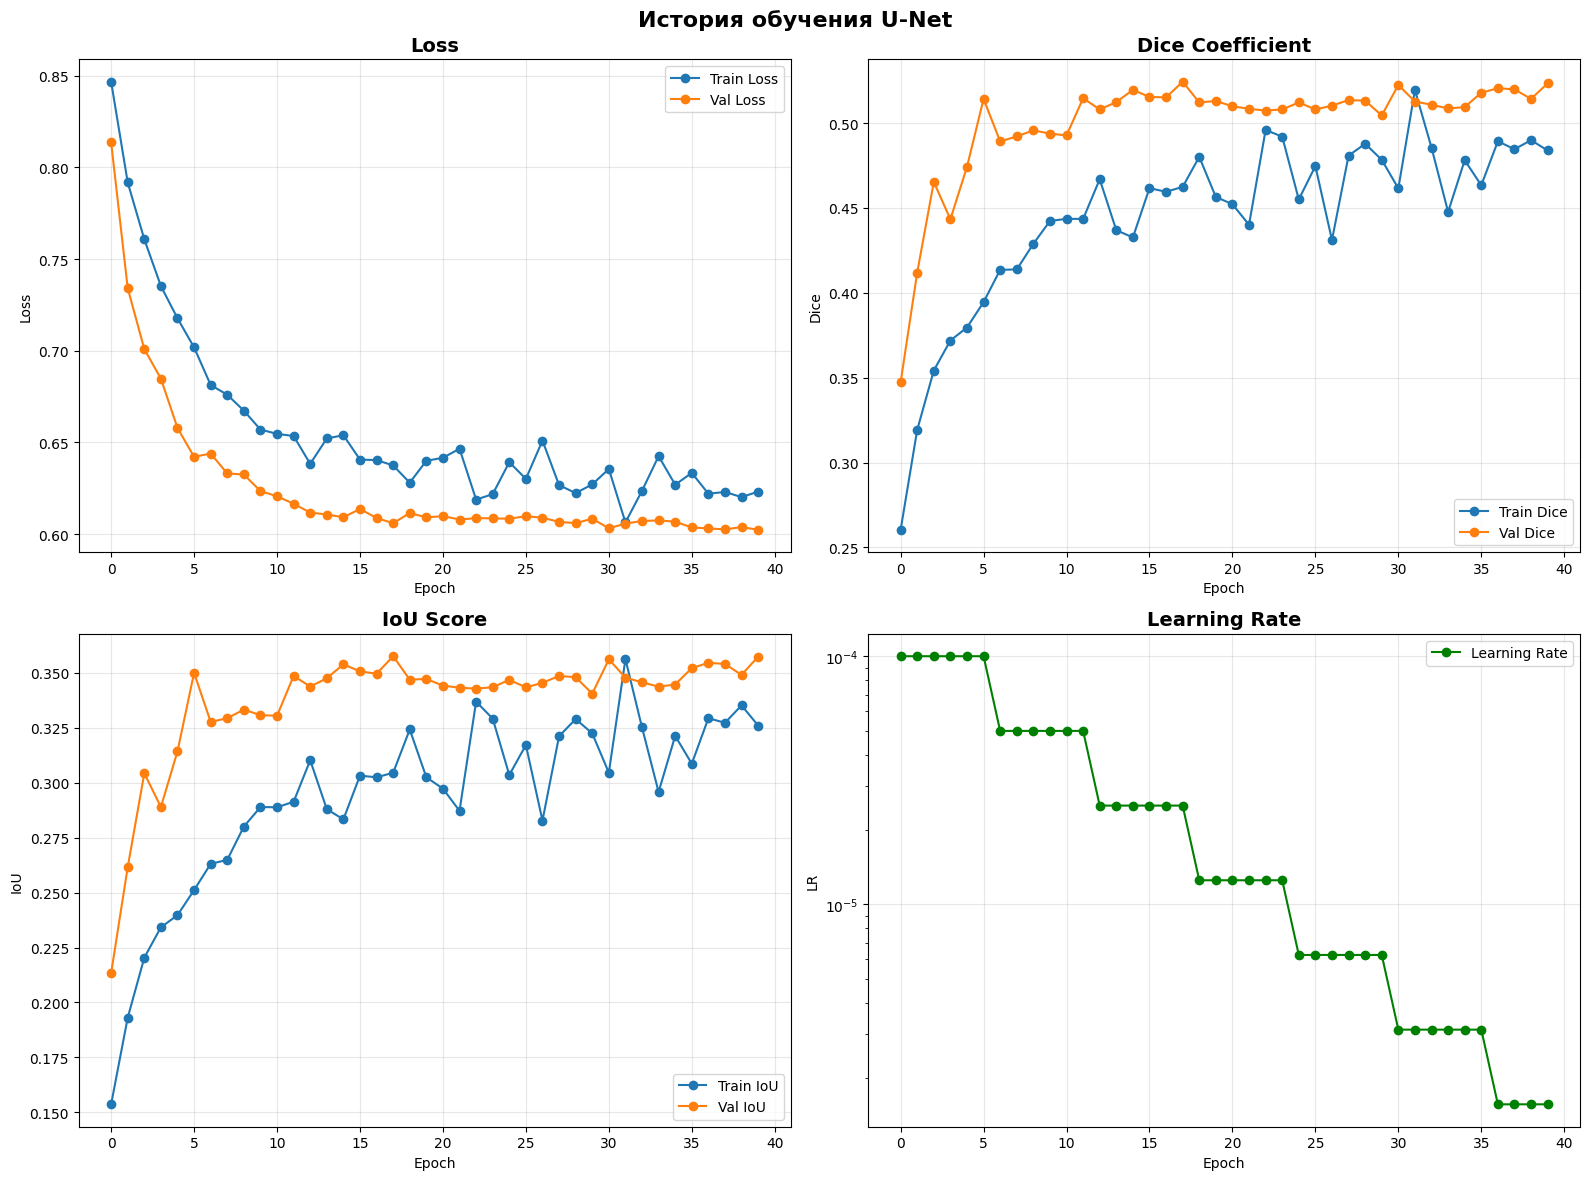

Train Loss: 0.6232
Val Loss: 0.6023
Train Dice: 0.4838
Val Dice: 0.5234
Train IoU: 0.3261
Val IoU: 0.3574
Val Accuracy: 0.8917


In [59]:
plot_training_history(resnet_history)


In [109]:
best_resnet_model = UNetWithCustomCNNBackbone(
    backbone=classifier,
    out_channels=1,
    freeze_encoder=False
).to(device)

checkpoint = torch.load('/kaggle/working/best_resnet18_unet_B.pth', map_location=device)
best_resnet_model.load_state_dict(checkpoint['model_state_dict'])
best_resnet_model = best_resnet_model.to(device)

print(f"Эпоха: {checkpoint['epoch'] + 1}")
print(f"Val Dice: {checkpoint['val_dice']:.4f}")
print(f"Val IoU: {checkpoint['val_iou']:.4f}")



Эпоха: 18
Val Dice: 0.5243
Val IoU: 0.3576


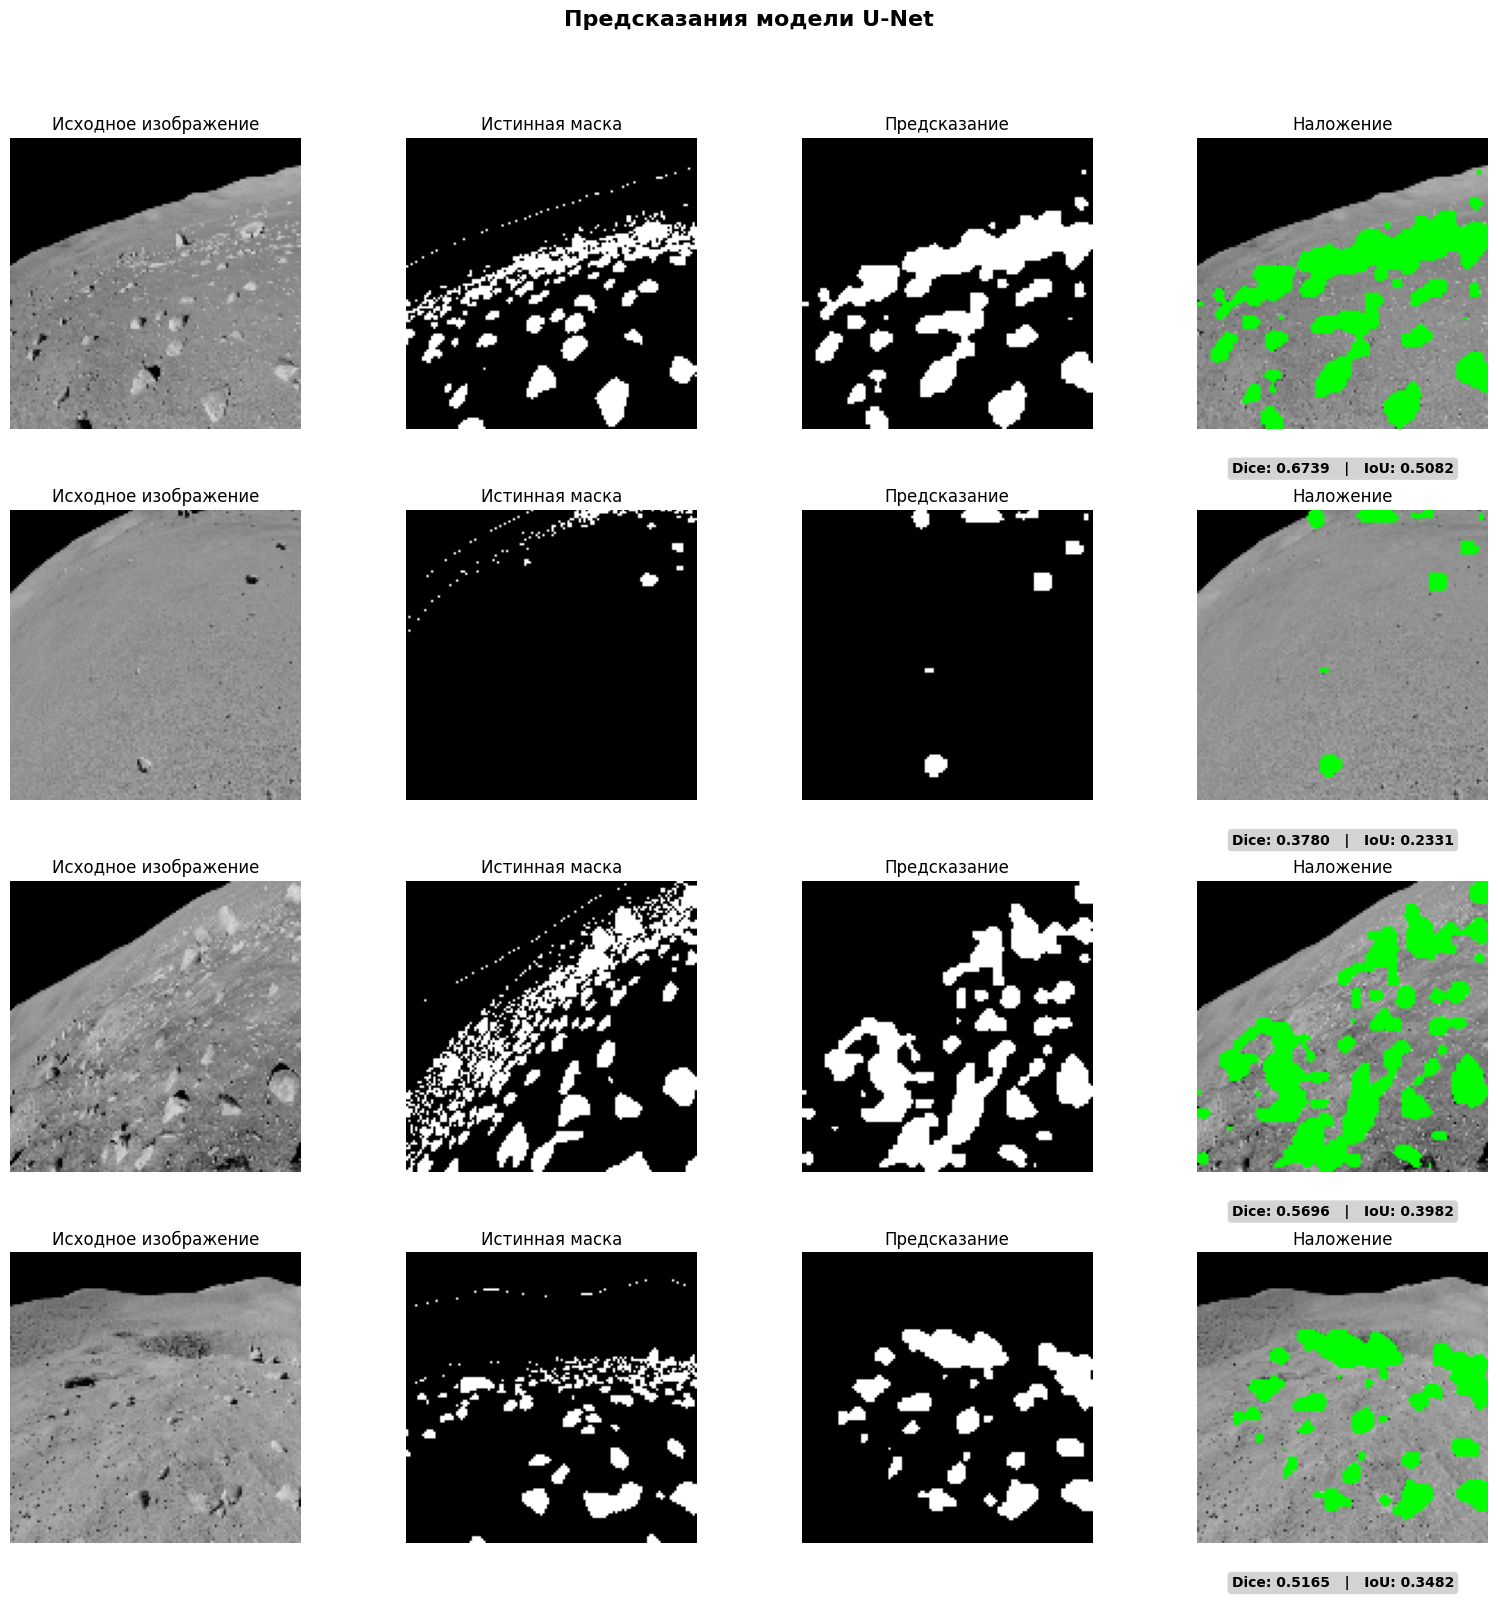

In [82]:
visualize_predictions(best_resnet_model, val_loader, device, num_samples=4)

### Сравнение моделей: U-Net vs ResNet18-UNet

Давайте сравним результаты обеих моделей на одних и тех же изображениях.


In [103]:
def compare_models(simple_model, resnet_model, dataloader, device, num_samples=3, names=["U-Net", "ResNet-UNet"]):

    simple_model.eval()
    resnet_model.eval()

    images_list = []
    masks_list = []

    for images, masks in dataloader:
        images_list.append(images)
        masks_list.append(masks)
        if sum(len(b) for b in images_list) >= num_samples:
            break
    images = torch.cat(images_list, dim=0)[:num_samples]
    masks = torch.cat(masks_list, dim=0)[:num_samples]
    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        simple_preds = simple_model(images)
        simple_preds = (simple_preds > 0.5).float()

        resnet_preds = resnet_model(images)
        resnet_preds = (resnet_preds > 0.5).float()

    images = images.cpu()
    masks = masks.cpu()
    simple_preds = simple_preds.cpu()
    resnet_preds = resnet_preds.cpu()

    fig, axes = plt.subplots(num_samples, 5, figsize=(16, 4*num_samples))

    for i in range(min(num_samples, len(images))):
        img = denormalize(images[i]).permute(1, 2, 0).numpy()
        if masks.dim() == 4:  # [B, 1, H, W]
          mask_true = masks[i, 0].numpy()
        elif masks.dim() == 3:  # [B, H, W]
          mask_true = masks[i].numpy()
        #mask_true = masks[i, 0].numpy()
        simple_pred = simple_preds[i, 0].numpy()
        resnet_pred = resnet_preds[i, 0].numpy()

        axes[i, 0].imshow(img)
        axes[i, 0].set_title('Исходное', fontsize=12)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(mask_true, cmap='gray')
        axes[i, 1].set_title('Ground Truth', fontsize=12)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(simple_pred, cmap='gray')
        simple_dice = dice_coefficient(simple_preds[i:i+1], masks[i:i+1])
        simple_iou = iou_score(simple_preds[i:i+1], masks[i:i+1])
        axes[i, 2].set_title(f'{names[0]} \nDice: {simple_dice:.3f} | IoU: {simple_iou:.3f}', fontsize=10)
        axes[i, 2].axis('off')

        axes[i, 3].imshow(resnet_pred, cmap='gray')
        resnet_dice = dice_coefficient(resnet_preds[i:i+1], masks[i:i+1])
        resnet_iou = iou_score(resnet_preds[i:i+1], masks[i:i+1])
        axes[i, 3].set_title(f'{names[1]}\nDice: {resnet_dice:.3f} | IoU: {resnet_iou:.3f}', fontsize=10)
        axes[i, 3].axis('off')

        diff = np.abs(simple_pred - resnet_pred)
        axes[i, 4].imshow(diff, cmap='hot')
        axes[i, 4].set_title('Difference\n(white = disagree)', fontsize=10)
        axes[i, 4].axis('off')

    plt.suptitle(f'Сравнение моделей {names[0]} и {names[1]}', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

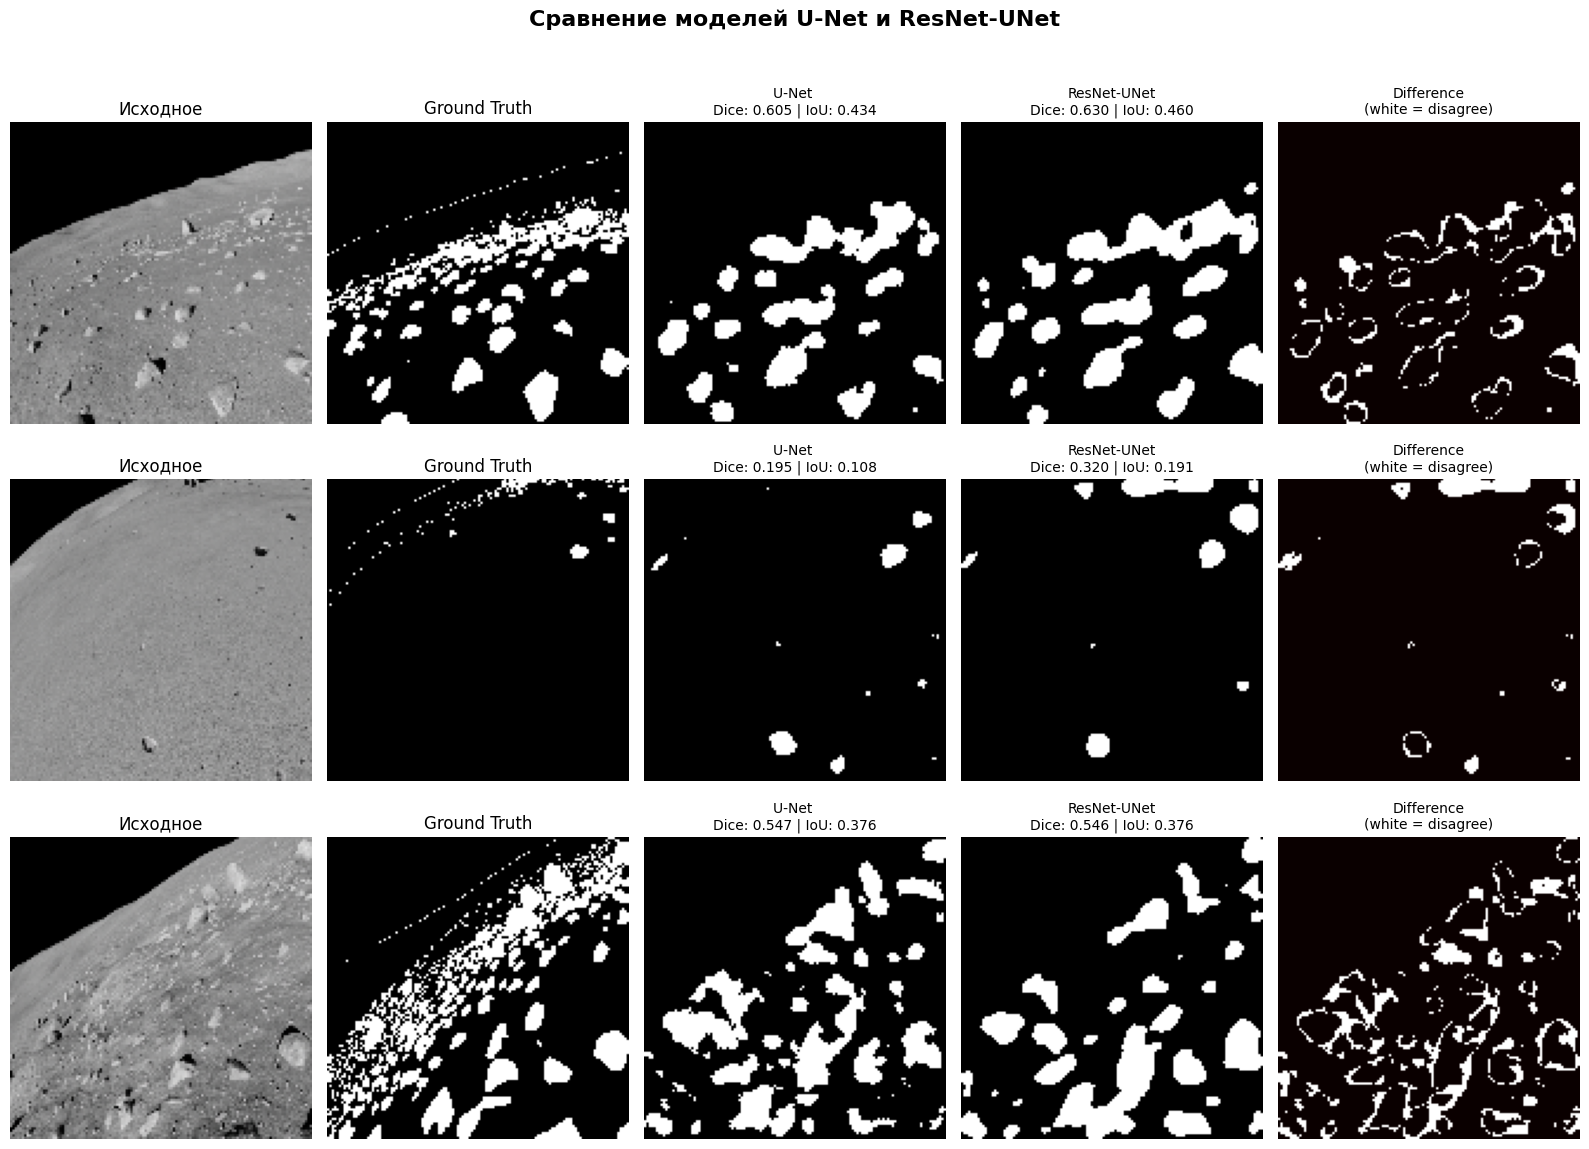

In [104]:
compare_models(best_model_unet, best_resnet_unetA, val_loader, device, num_samples=3)

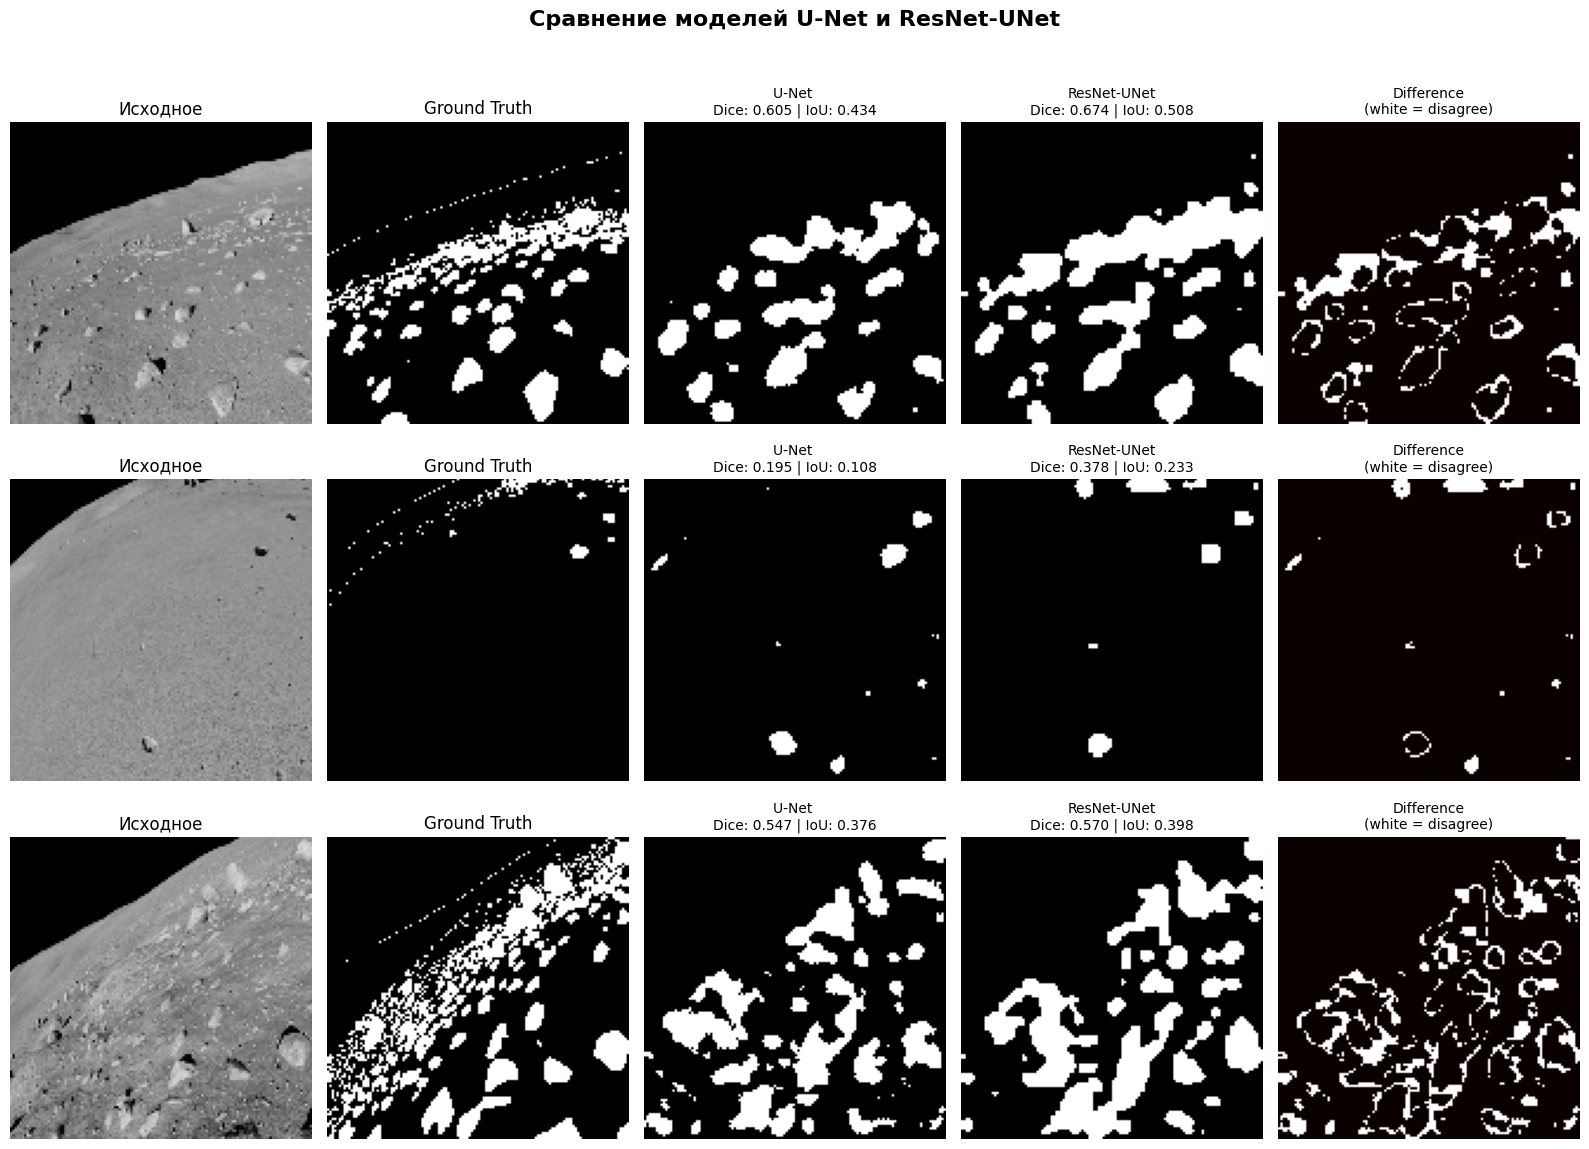

In [105]:
compare_models(best_model_unet, best_resnet_model, val_loader, device, num_samples=3)

# Результаты

In [112]:
comparison_data = {
    'Model': [
        'Basic U-Net',
        'U-Net + Frozen Encoder',
        'U-Net + Fine-tuned Encoder'
    ],
    'Parameters (M)': [
        1934306,
        3810187,
        3810187
    ],
    'Trainable Params (M)': [
        1934306,
        1032513,
        3810187
    ],
    'Best Val IoU': [
        0.3226,
        0.2934,
        0.3576
    ],
    'Best Val Dice': [
        0.4843,
        0.4495,
        0.5243 
    ],
    'Best Val Pixel Acc': [
        0.8911,
        0.8654,
        0.8864
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print('Сравнительная таблица')
print(df_comparison.to_string(index=False))

Сравнительная таблица
                     Model  Parameters (M)  Trainable Params (M)  Best Val IoU  Best Val Dice  Best Val Pixel Acc
               Basic U-Net         1934306               1934306        0.3226         0.4843              0.8911
    U-Net + Frozen Encoder         3810187               1032513        0.2934         0.4495              0.8654
U-Net + Fine-tuned Encoder         3810187               3810187        0.3576         0.5243              0.8864


По IoU и Dice U-Net + Fine-tuned Encoder показал наилучшие результаты (но и количество обучаемых параметров самое высокое).  
U-Net + Frozen Encoder показал наихудшие результаты по всем метрикам. 